# Tutorial 1: Basics


In this tutorial you will learn how to:
* run LightAutoML training on tabular data
* obtain feature importances and reports
* configure resource usage in LightAutoML

Official LightAutoML github repository is [here](https://github.com/AILab-MLTools/LightAutoML)

![](https://raw.githubusercontent.com/sb-ai-lab/LightAutoML/39cb56feae6766464d39dd2349480b97099d2535/imgs/LightAutoML_logo_big.png)

## 0. Prerequisites

### 0.0. install LightAutoML

In [ ]:
!pip install -U lightautoml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 319 kB 28.7 MB/s 
     |████████████████████████████████| 525 kB 64.8 MB/s 
     |████████████████████████████████| 804.1 MB 3.0 kB/s 
     |████████████████████████████████| 348 kB 79.1 MB/s 
     |████████████████████████████████| 215 kB 66.7 MB/s 
     |████████████████████████████████| 2.0 MB 56.9 MB/s 
     |████████████████████████████████| 76.6 MB 1.2 MB/s 
     |████████████████████████████████| 2.8 MB 62.0 MB/s 
     |████████████████████████████████| 209 kB 74.7 MB/s 
     |████████████████████████████████| 81 kB 8.1 MB/s 
     |████████████████████████████████| 78 kB 6.6 MB/s 
     |████████████████████████████████| 112 kB 68.9 MB/s 
     |████████████████████████████████| 49 kB 6.2 MB/s 
     |████████████████████████████████| 147 kB 60.6 MB/s 
  Created wheel for json2html: filename=json2html-1.3.0-py3-none-any.whl size=7609 sha256=bfd4

### 0.1. Import libraries

Here we will import the libraries we use in this kernel:
- Standard python libraries for timing, working with OS and HTTP requests etc.
- Essential python DS libraries like numpy, pandas, scikit-learn and torch (the last we will use in the next cell)
- LightAutoML modules: presets for AutoML, task and report generation module

In [ ]:
# Standard python libraries
import os
import time
import requests

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

### 0.2. Constants

Here we setup some parameters to use in the kernel:
- `N_THREADS` - number of vCPUs for LightAutoML model creation
- `N_FOLDS` - number of folds in LightAutoML inner CV
- `RANDOM_STATE` - random seed for better reproducibility
- `TEST_SIZE` - houldout data part size 
- `TIMEOUT` - limit in seconds for model to train
- `TARGET_NAME` - target column name in dataset

In [ ]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 300
TARGET_NAME = 'TARGET'

In [ ]:
!mkdir data

In [ ]:
DATASET_DIR = './data/'
DATASET_NAME = 'sampled_app_train.csv'
DATASET_FULLNAME = os.path.join(DATASET_DIR, DATASET_NAME)
DATASET_URL = 'https://raw.githubusercontent.com/AILab-MLTools/LightAutoML/master/examples/data/sampled_app_train.csv'

### 0.3. Imported models setup

For better reproducibility fix numpy random seed with max number of threads for Torch (which usually try to use all the threads on server):

In [ ]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

### 0.4. Data loading
Let's check the data we have:

In [ ]:
if not os.path.exists(DATASET_FULLNAME):
    os.makedirs(DATASET_DIR, exist_ok=True)

    dataset = requests.get(DATASET_URL).text
    with open(DATASET_FULLNAME, 'w') as output:
        output.write(dataset)

In [ ]:
data = pd.read_csv('./data/sampled_app_train.csv')
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,313802,0,Cash loans,M,N,Y,0,270000.0,327024.0,15372.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,319656,0,Cash loans,F,N,N,0,108000.0,675000.0,19737.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,207678,0,Revolving loans,F,Y,Y,2,112500.0,270000.0,13500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,381593,0,Cash loans,F,N,N,1,67500.0,142200.0,9630.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
4,258153,0,Cash loans,F,Y,Y,0,337500.0,1483231.5,46570.5,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,0.0


In [ ]:
data.shape

(10000, 122)

### 0.5. Data splitting for train-holdout
As we have only one file with target values, we can split it into 80%-20% for holdout usage:

In [ ]:
tr_data, te_data = train_test_split(
    data, 
    test_size=TEST_SIZE, 
    stratify=data[TARGET_NAME], 
    random_state=RANDOM_STATE
)

print(f'Data is splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')

tr_data.head()

Data is splitted. Parts sizes: tr_data = (8000, 122), te_data = (2000, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
6444,112261,0,Cash loans,F,N,N,1,90000.0,640080.0,31261.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
3586,115058,0,Cash loans,F,N,Y,0,180000.0,239850.0,23850.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
9349,326623,0,Cash loans,F,N,Y,0,112500.0,337500.0,31086.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
7734,191976,0,Cash loans,M,Y,Y,1,67500.0,135000.0,9018.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2174,281519,0,Revolving loans,F,N,Y,0,67500.0,202500.0,10125.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


It is important to note that missing values (NaN and other) in the data should be left as is, unless the reason for their presence or their specific meaning are known. Otherwise, AutoML model will perceive the filled NaNs as a true pattern between the data and the target variable, without knowledge and assumptions about missing values, which can negatively affect the model quality. LighAutoML can deal with missing values and outliers automatically.

## 1. Task definition

### 1.1. Task type

First we need to create ```Task``` object - the class to setup what task LightAutoML model should solve with specific loss and metric if necessary (more info can be found [here](https://lightautoml.readthedocs.io/en/latest/pages/modules/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task) in our documentation).

The following task types are available:

- ```'binary'``` - for binary classification.

- ```'reg’``` - for regression.

- ```‘multiclass’``` - for multiclass classification.

- ```'multi:reg``` - for multiple regression.

- ```'multilabel'``` - for multi-label classification.

In this example we will consider a binary classification:

In [ ]:
task = Task('binary')

Note that only logloss loss is available for binary task and it is the default loss. Default metric for binary classification is ROC-AUC. See more info about available and default losses and metrics [here](https://lightautoml.readthedocs.io/en/latest/pages/modules/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task). 

**Depending on the task, you can and shold choose exactly those metrics and losses that you want and need to optimize.**

### 1.2. Feature roles setup

To solve the task, we need to setup columns roles. LightAutoML can automatically define types and roles of data columns, but it is possible to specify it directly through the dictionary parameter ```roles``` when training AutoML model (see next section "AutoML training"). Specific roles can be specified using a string with the name (any role can be set like this).  So the key in dictionary must be the name of the role, the value must be a list of the names of the corresponding columns in dataset. The **only role you must setup is** ```'target'``` **role** (that is column with target variable obviously), everything else (```'drop', 'numeric', 'categorical', 'group', 'weights'``` etc) is up to user:

In [ ]:
roles = {
    'target': TARGET_NAME,
    'drop': ['SK_ID_CURR']
}

You can also optionally specify the following roles:

- ```'numeric'``` - numerical feature

- ```'category'``` - categorical feature

- ```'text'``` - text data

- ```'datetime'``` - features with date and time 

- ```'date'``` - features with date only

- ```'group'``` - features by which the data can be divided into groups and which can be taken into account for group k-fold validation (so the same group is not represented in both testing and training sets)

- ```'drop'``` - features to drop, they will not be used in model building

- ```'weights'``` - object weights for the loss and metric

- ```'path'``` - image file paths (for CV tasks)

- ```'treatment'``` - object group in uplift modelling tasks: treatment or control

Note that role name can be written in any case. Also it is possible to pass individual objects of role classes with specific arguments instead of strings with role names for specific tasks and more optimal pipeline construction ([more details](https://github.com/sb-ai-lab/LightAutoML/blob/master/lightautoml/dataset/roles.py)).

For example, to set the date role, you can use the ```DatetimeRole``` class. 

In [ ]:
from lightautoml.dataset.roles import DatetimeRole

Different seasonality can be extracted from the data through the ```seasonality``` parameter: years (```'y'```), months (```'m'```), days (```'d'```), weekdays (```'wd'```), hours (```'hour'```), minutes (```'min'```), seconds (```'sec'```), milliseconds (```'ms'```), nanoseconds (```'ns'```). This features will be considered as categorical. Another important parameter is ```base_date```. It allows to specify the base date and convert the feature to the distances to this date (set to ```False``` by default). Also for all roles classes there is a ```force_input``` parameter, and if it is ```True```, then the corresponding features will pass all further feature selections and won't be excluded (equals ```False``` by default). Also it is always possible to specify data type for all roles using ```dtype``` argument.

Here is an example of such a role assignment through a class object for date feature (but there is no such feature in the considered dataset):

In [ ]:
roles = {
    DatetimeRole(base_date=False, seasonality=('d', 'wd', 'hour')): 'date_time'
}

Any role can be set through a class object. Information about specific parameters of specific roles and other datailed information can be found [here](https://github.com/sb-ai-lab/LightAutoML/blob/master/lightautoml/dataset/roles.py).

### 1.3. LightAutoML model creation - TabularAutoML preset

Next we are going to create LightAutoML model with `TabularAutoML` class - preset with default model structure in just several lines. 

In general, the whole AutoML model consists of multiple levels, which can contain several pipelines with their own set of data processing methods and ML models. The outputs of one level are the inputs of the next, and on the last level predictions of previous level models are combined with blending procedure. All this can be combined into a model using the ```AutoML``` class and its various descendants (like ```TabularAutoML```).

Let's look at how the LightAutoML model is arranged and what it consists in general.

![](https://raw.githubusercontent.com/sb-ai-lab/LightAutoML/master/imgs/tutorial_1_laml_big.png)

#### 1.3.1 Reader object

First the task and data go into ```Reader``` object. It analyzes the data and extracts various valuable information from them. Also it can detect and remove useless features, conduct feature selection, determine types and roles etc. Let's look at this steps in more detail.

**Role and types guessing**

Roles can be specified as a string or a specific class object, or defined automatically. For ```TabularAutoML``` preset ```'numeric'```, ```'datetime'``` and ```'category'``` roles can be automatically defined. There are two ways of role defining. **First** is very simple: check if the value can be converted to a date (```'datetime'```), otherwise check if it can be converted to a number (```'numeric'```), otherwise declare it a category (```'categorical'```). But this method may not work well on large data or when encoding categories with integers. The **second** method is based on statistics: the distributions of numerical features are considered, and how similar they are to the distributions of real or categorical value. Also different ways of feature encoding (as a number or as a category) are compared and based on normalized Gini index it is decided which encoding is better. For this case a set of specific rules is created, and if at least one of them is fullfilled, then the feature will be assigned to numerical, otherwise to categorical. This check can be enabled or disabled using the ```advanced_roles``` parameter. 

If roles are explicitly specified, automatic definition won't be applied to the specified dataset columns. In the case of specifying a role as an object of a certain class, through its arguments, it is possible to set the processing parameters in more detail.
 
**Feature selection**

In general, the AutoML pipeline uses pre-selection, generation and post-selection of features. ```TabularAutoML``` has no post-selection stage. There are three feature selection methods: its absence, using features importances and more strict selection (forward selection). The GBM model is used to evaluate features importances. Importances can be calculated in 2 ways: based on splits (how many times a split was made for each feature in the entire ensemble) or using permutation feature importances (mixing feature values during validation and assessing quality change in this case). Second method is harder but it requires holdout data. Then features with importance above a certain threshold are selected. Faster and more strict feature selection method is forward selection. Features are sorted in descending order of importance, then in blocks (size of 1 by default) a model is built based on selected features, and its quality is measured. Then the next block of features is added, and they are saved if the quality has improved with them, and so on.  

Also LightAutoML can merge some columns if it is adequate and leads to an improvement in the model quality (for example, an intersection between categorical variables). Different columns join options are considered, the best one is chosen by the normalized Gini index. 

#### 1.3.2 Machine learning pipelines architecture and training

As a result, after analyzing and processing the data, the ```Reader``` object forms and returns a ```LAMA Dataset```. It contains the original data and markup with metainformation. In this dataset it is possible to see the roles defined by the ```Reader``` object, selected features etc. Then ML pipelines are trained on this data. 

![](https://raw.githubusercontent.com/sb-ai-lab/LightAutoML/master/imgs/tutorial_1_ml_pipeline.png)

Each such pipeline is one or more machine learning algorithms that share one post-processing block and one validation scheme. Several such pipelines can be trained in parallel on one dataset, and they form a level. Number of levels can be unlimited as possible. List of all levels of AutoML pipeline is available via ```.levels``` attribute of ```AutoML``` instance. Level predictions can be inputs to other models or ML pipelines (i. e. stacking scheme). As inputs for subsequent levels, it is possible to use the original data by setting ```skip_conn``` argument in ```True``` when initializing preset instance. At the last level, if there are several pipelines, blending is used to build a prediction. 

Different types of features are processed depending on the models. Numerical features are processed for linear model preprocessing: standardization, replacing missing values with median, discretization, log odds (if feature is probability - output of previous level). Categories are processed using label encoding (by default), one hot encoding, ordinal encoding, frequency encoding, out of fold target encoding. 

The following algorithms are available in the LightAutoML: linear regression with L2 regularization, LightGBM, CatBoost, random forest. 

By default KFold cross-validation is used during training at all levels (for hyperparameter optimization and building out-of-fold prediction during training), and for each algorithm a separate model is built for each validation fold, and their predictions are averaged. So the predictions at each level and the resulting prediction during training are out-of-fold predictions. But it is also possible to just pass a holdout data for validation or use custom cross-validation schemes, setting ```cv_iter``` iterator returning the indices of the objects for validation. LightAutoML has ready-made iterators, for example, ```TimeSeriesIterator``` for time series split. To further reduce the effect of overfitting, it is possible to use nested cross-validation (```nested_cv``` parameter), but it is not used by default. 

Prediction on new data is the averaging of models over all folds from validation and blending. 

Hyperparameter tuning of machine learning algorithms can be performed during training (early stopping by the number of trees in gradient boosting or the number of training epochs of neural networks etc), based on expert rules (according to data characteristics and empirical recommendations, so-called expert parameters), by the sequential model-based optimization (SMBO, bayesian optimization: Optuna with TPESampler) or by grid search. LightGBM and CatBoost can be used with parameter tuning or with expert parameters, with no tuning. For linear regression parameters are always tuned using warm start model training technique. 

At the last level blending is used to build a prediction. There are three available blending methods: choosing the best model based on a given metric (other models are just discarded), simple averaging of all models, or weighted averaging (weights are selected using coordinate descent algorithm with optimization of a given metric). ```TabularAutoML ``` uses the latter strategy by default. It is worth noting that, unlike stacking, blending can exclude models from composition. 

#### 1.3.3 Timing

When creating AutoML object, a certain time limit is set, and it schedules a list of tasks that it can complete during this time, and it will initially allocate approximately equal time for each task. In the process of solving objectives, it understands how to adjust the time allocated to different subtasks. If AutoML finished working earlier than set timeout, it means that it completed the entire list of tasks. If AutoML worked to the limit and turned off, then most likely it sacrificed something, for example, reduced the number of algorithms for training, realized that it would not have time to train the next one, or it might not calculate the full cross-validation cycle for one of the models (then on folds, where the model has not trained, the predictiuons will be NaN, and the model related to this fold will not participate in the final averaging). The resulting quality is evaluated at the blending stage, and if necessary and possible, the composition will be corrected. 

If you do not set the time for AutoML during initialization, then by default it will be equal to a very large number, that is, sooner or later AutoML will complete all tasks. 

#### 1.3.4 LightAutoML model creation

So the entire AutoML pipeline can be composed from various parts by user (see [custom pipeline tutorial](https://github.com/sb-ai-lab/LightAutoML/blob/master/examples/tutorials/Tutorial_6_custom_pipeline.ipynb)), but it is possible to use presets - in a certain sense, fixed strategies for dynamic pipeline building. 

Here is a default AutoML pipeline for binary classification and regression tasks (```TabularAutoML``` preset):

![](https://raw.githubusercontent.com/sb-ai-lab/LightAutoML/ac3c1b38873437eb74354fb44e68a449a0200aa6/imgs/tutorial_blackbox_pipeline.png)

Another example:

![](https://raw.githubusercontent.com/sb-ai-lab/LightAutoML/ac3c1b38873437eb74354fb44e68a449a0200aa6/imgs/tutorial_1_pipeline.png)

Let's discuss some of the params we can setup:
- `task` - the type of the ML task (the only **must have** parameter)
- `timeout` - time limit in seconds for model to train
- `cpu_limit` - vCPU count for model to use
- `reader_params` - parameter change for ```Reader``` object inside preset, which works on the first step of data preparation: automatic feature typization, preliminary almost-constant features, correct CV setup etc. For example, we setup `n_jobs` threads for typization algo, `cv` folds and `random_state` as inside CV seed.
- `general_params` - general parameters dictionary, in which it is possible to specify a list of algorithms used (```'use_algos'```), nested CV using (```'nested_cv'```) etc.

**Important note**: `reader_params` key is one of the YAML config keys, which is used inside `TabularAutoML` preset. [More details](https://github.com/sb-ai-lab/LightAutoML/blob/master/lightautoml/automl/presets/tabular_config.yml) on its structure with explanation comments can be found on the link attached. Each key from this config can be modified with user settings during preset object initialization. To get more info about different parameters setting (for example, ML algos which can be used in `general_params->use_algos`) please take a look at our [article on TowardsDataScience](https://towardsdatascience.com/lightautoml-preset-usage-tutorial-2cce7da6f936).

Moreover, to receive the automatic report for our model we will use `ReportDeco` decorator and work with the decorated version in the same way as we do with usual one. 

In [ ]:
automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)

## 2. AutoML training

To run autoML training use ```fit_predict``` method. 

Main arguments:

- `train_data` - dataset to train.
- `roles` - column roles dict.
- `verbose` - controls the verbosity: the higher, the more messages:
        <1  : messages are not displayed;
        >=1 : the computation process for layers is displayed;
        >=2 : the information about folds processing is also displayed;
        >=3 : the hyperparameters optimization process is also displayed;
        >=4 : the training process for every algorithm is displayed;

Note: out-of-fold prediction is calculated during training and returned from the fit_predict method

In [ ]:
%%time 
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 4)

[08:05:23] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[08:05:23] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer


[08:05:23] Task: binary



INFO:lightautoml.automl.presets.base:Task: binary



[08:05:23] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[08:05:23] - time: 300.00 seconds


INFO:lightautoml.automl.presets.base:- time: 300.00 seconds


[08:05:23] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[08:05:23] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[08:05:23] Train data shape: (8000, 122)



INFO:lightautoml.reader.base:Train data shape: (8000, 122)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[08:05:28] Layer 1 train process start. Time left 294.88 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 294.88 secs


[08:05:29] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183], 'embed_sizes': array([20,  8,  9,  3,  5,  6,  3,  9,  3,  6,  6, 10,  3,  6,  8,  3],
      dtype=int32), 'data_size': 184}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.6793490172180616
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.700987860224193
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.7198550283047612
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear 

[08:05:36] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.735446338918961


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.735446338918961


[08:05:36] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[08:05:37] Time left 286.35 secs



INFO:lightautoml.automl.base:Time left 286.35 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.74182
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.749544
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.749218
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[194]	valid's auc: 0.751089


[08:05:43] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[08:05:44] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 32, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 0.5, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.748823
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.757889
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.763544
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.761839
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	

[08:06:11] Time limit exceeded after calculating fold 2



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 2



[08:06:11] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.7455812488066815


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.7455812488066815


[08:06:11] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[08:06:11] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1.00 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-497fd712-9cdc-4364-981d-e447d85ea552
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.740206
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.739762
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.744049
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.745311
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.74654
DEBUG:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.746235
DEBUG:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.746348
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[547]	valid's auc: 0.747294
INFO:optuna.study.study:Trial 0 finished with value: 0.7472938082332375 and parameters: 

[08:06:41] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}
 achieve 0.7473 auc


[08:06:41] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 5000, 'learning_rate': 0.035, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.5347301	best: 0.5347301 (0)	total: 53.7ms	remaining: 4m 28s
DEBUG:lightautoml.ml_algo.boost_cb:100:	test: 0.7142636	best: 0.7160650 (90)	total: 629ms	remaining: 30.5s
DEBUG:lightautoml.ml_algo.boost_cb:200:	test: 0.7219131	best: 0.7284988 (130

[08:06:49] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.7106082281550251


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.7106082281550251


[08:06:49] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[08:06:49] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 127.81 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 127.81 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-67bc7969-06c7-41cf-a281-f921883ac7d0
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.4934330	best: 0.4934330 (0)	total: 4.28ms	remaining: 21.4s
DEBUG:lightautoml.ml_algo.boost_cb:100:	test: 0.7502820	best: 0.7502820 (100)	total: 416ms	remaining: 20.2s
DEBUG:lightautoml.ml_algo.boost_cb:200:	test: 0.7489777	best: 0.7543820 (182)	total: 843ms	remaining: 20.1s
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.7543820261
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 182
INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 183 iterations.
INFO:optuna.study.study:Trial 0 finished with value: 0.7543820260756612 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.

[08:08:57] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0035985555288043473, 'min_data_in_leaf': 7}
 achieve 0.7676 auc


[08:08:57] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.0035985555288043473, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'min_data_in_leaf': 7, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Max', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.4934330	best: 0.4934330 (0)	total: 3.81ms	remaining: 11.4s
DEBUG:lightautoml.ml_algo.boost_cb:100:	test: 0.7457543	best: 0.7518963 (86)	total: 434ms	remaining: 12.5s
DEBUG:lightautoml.ml_algo.boost_cb:200:	test: 0.7

[08:09:05] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.7366404042452727


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.7366404042452727


[08:09:05] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


[08:09:05] Time left 77.57 secs



INFO:lightautoml.automl.base:Time left 77.57 secs



[08:09:05] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



INFO:lightautoml.automl.base:Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



[08:09:05] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[08:09:05] Blending: optimization starts with equal weights and score 0.7429235711025348


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights and score 0.7429235711025348


[08:09:05] Blending: iteration 0: score = 0.7479612235443787, weights = [0.32556826 0.28717405 0.         0.38725773]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = 0.7479612235443787, weights = [0.32556826 0.28717405 0.         0.38725773]


[08:09:06] Blending: iteration 1: score = 0.7479859913909941, weights = [0.34675896 0.2568501  0.         0.39639094]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = 0.7479859913909941, weights = [0.34675896 0.2568501  0.         0.39639094]


[08:09:06] Blending: iteration 2: score = 0.7479859913909941, weights = [0.34675896 0.2568501  0.         0.39639094]


INFO:lightautoml.automl.blend:Blending: iteration 2: score = 0.7479859913909941, weights = [0.34675896 0.2568501  0.         0.39639094]


[08:09:06] Blending: no score update. Terminated



INFO:lightautoml.automl.blend:Blending: no score update. Terminated



[08:09:06] Automl preset training completed in 222.83 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 222.83 seconds



[08:09:06] Model description:
Final prediction for new objects (level 0) = 
	 0.34676 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.25685 * (3 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.39639 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 0.34676 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.25685 * (3 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.39639 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 



CPU times: user 6min 15s, sys: 17.2 s, total: 6min 32s
Wall time: 3min 42s


After training we can see logs with all the progress, final scores, weights assigned to the models in the final prediction etc.

Note that in this `fit_predict` you receive the model with only 3 out of 5 LightGBM models (you can see that from the log line in the end `0.25685 * (3 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM)`) - to fix it you can set the bigger timeout to make LightAutoML train all the models.

## 3. Prediction on holdout and model evaluation

Now we can use trained AutoML model to build predictions on holdout and evaluate model quality. Note that in case of classification tasks LightAutoML model returns probabilities as predictions.

In [ ]:
%%time

te_pred = automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[0.07381193],
       [0.07863363],
       [0.0354104 ],
       ...,
       [0.07275955],
       [0.05246619],
       [0.21107544]], dtype=float32)
Shape = (2000, 1)
CPU times: user 1.04 s, sys: 5.96 ms, total: 1.04 s
Wall time: 805 ms


In [ ]:
print(f'OOF score: {roc_auc_score(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])}')
print(f'HOLDOUT score: {roc_auc_score(te_data[TARGET_NAME].values, te_pred.data[:, 0])}')

OOF score: 0.7479859913909941
HOLDOUT score: 0.7311922554347826


## 4. Model analysis

### 4.1. Reports

You can obtain the description of the resulting pipeline:

In [ ]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.34676 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.25685 * (3 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.39639 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


Also for this purposes LightAutoML have ```ReportDeco```, use it to build detailed reports:

In [ ]:
RD = ReportDeco(output_path = 'tabularAutoML_model_report')

automl_rd = RD(
    TabularAutoML(
        task = task, 
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
    )
)

In [ ]:
%%time
oof_pred = automl_rd.fit_predict(tr_data, roles = roles, verbose = 4)

[08:24:51] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[08:24:51] Task: binary



INFO:lightautoml.automl.presets.base:Task: binary



[08:24:51] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[08:24:51] - time: 300.00 seconds


INFO:lightautoml.automl.presets.base:- time: 300.00 seconds


[08:24:51] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[08:24:51] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[08:24:51] Train data shape: (8000, 122)



INFO:lightautoml.reader.base:Train data shape: (8000, 122)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[08:24:56] Layer 1 train process start. Time left 294.89 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 294.89 secs


[08:24:57] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183], 'embed_sizes': array([20,  8,  9,  3,  5,  6,  3,  9,  3,  6,  6, 10,  3,  6,  8,  3],
      dtype=int32), 'data_size': 184}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.6793490172180616
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.700987860224193
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.7198550283047612
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear 

[08:25:04] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.735446338918961


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.735446338918961


[08:25:04] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[08:25:04] Time left 286.85 secs



INFO:lightautoml.automl.base:Time left 286.85 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.74182
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.749544
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.749218
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[194]	valid's auc: 0.751089


[08:25:11] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[08:25:11] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 32, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 0.5, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.748823
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.757889
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.763544
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.761839
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	

[08:25:41] Time limit exceeded after calculating fold 2



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 2



[08:25:41] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.7455812488066815


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.7455812488066815


[08:25:41] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[08:25:41] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1.00 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-0efa91ef-bc71-4c8a-be16-942b55ee5925
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.740206
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.739762
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.744049
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.745311
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.74654
DEBUG:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.746235
DEBUG:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.746348
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[547]	valid's auc: 0.747294
INFO:optuna.study.study:Trial 0 finished with value: 0.7472938082332375 and parameters: 

[08:26:11] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}
 achieve 0.7473 auc


[08:26:11] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 5000, 'learning_rate': 0.035, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.5347301	best: 0.5347301 (0)	total: 8.15ms	remaining: 40.7s
DEBUG:lightautoml.ml_algo.boost_cb:100:	test: 0.7142636	best: 0.7160650 (90)	total: 629ms	remaining: 30.5s
DEBUG:lightautoml.ml_algo.boost_cb:200:	test: 0.7219131	best: 0.7284988 (130)

[08:26:19] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.7106082281550251


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.7106082281550251


[08:26:19] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[08:26:19] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 123.75 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 123.75 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-10768c2b-27ba-4ce9-81b8-4dc7e2e55f3e
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.4934330	best: 0.4934330 (0)	total: 4.93ms	remaining: 24.7s
DEBUG:lightautoml.ml_algo.boost_cb:100:	test: 0.7502820	best: 0.7502820 (100)	total: 455ms	remaining: 22.1s
DEBUG:lightautoml.ml_algo.boost_cb:200:	test: 0.7489777	best: 0.7543820 (182)	total: 906ms	remaining: 21.6s
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.7543820261
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 182
INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 183 iterations.
INFO:optuna.study.study:Trial 0 finished with value: 0.7543820260756612 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.

[08:28:23] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0035985555288043473, 'min_data_in_leaf': 7}
 achieve 0.7676 auc


[08:28:23] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.0035985555288043473, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'min_data_in_leaf': 7, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Max', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.4934330	best: 0.4934330 (0)	total: 4.32ms	remaining: 12.9s
DEBUG:lightautoml.ml_algo.boost_cb:100:	test: 0.7457543	best: 0.7518963 (86)	total: 469ms	remaining: 13.5s
DEBUG:lightautoml.ml_algo.boost_cb:200:	test: 0.7

[08:28:32] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.7366404042452727


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.7366404042452727


[08:28:32] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


[08:28:32] Time left 78.92 secs



INFO:lightautoml.automl.base:Time left 78.92 secs



[08:28:32] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



INFO:lightautoml.automl.base:Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



[08:28:32] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[08:28:32] Blending: optimization starts with equal weights and score 0.7429235711025348


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights and score 0.7429235711025348


[08:28:32] Blending: iteration 0: score = 0.7479612235443787, weights = [0.32556826 0.28717405 0.         0.38725773]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = 0.7479612235443787, weights = [0.32556826 0.28717405 0.         0.38725773]


[08:28:32] Blending: iteration 1: score = 0.7479859913909941, weights = [0.34675896 0.2568501  0.         0.39639094]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = 0.7479859913909941, weights = [0.34675896 0.2568501  0.         0.39639094]


[08:28:32] Blending: iteration 2: score = 0.7479859913909941, weights = [0.34675896 0.2568501  0.         0.39639094]


INFO:lightautoml.automl.blend:Blending: iteration 2: score = 0.7479859913909941, weights = [0.34675896 0.2568501  0.         0.39639094]


[08:28:32] Blending: no score update. Terminated



INFO:lightautoml.automl.blend:Blending: no score update. Terminated



[08:28:32] Automl preset training completed in 221.52 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 221.52 seconds



[08:28:32] Model description:
Final prediction for new objects (level 0) = 
	 0.34676 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.25685 * (3 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.39639 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 0.34676 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.25685 * (3 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.39639 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 



CPU times: user 6min 17s, sys: 16.9 s, total: 6min 34s
Wall time: 3min 46s


The report will be available in the folder with specified name (```output_path``` argument in ```ReportDeco``` initialization).

In [ ]:
!ls tabularAutoML_model_report

feature_importance.png		  valid_pr_curve.png
lama_interactive_report.html	  valid_preds_distribution_by_bins.png
valid_distribution_of_logits.png  valid_roc_curve.png
valid_pie_f1_metric.png


In [ ]:
%%time

te_pred = automl_rd.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[0.07381193],
       [0.07863363],
       [0.0354104 ],
       ...,
       [0.07275955],
       [0.05246619],
       [0.21107544]], dtype=float32)
Shape = (2000, 1)
CPU times: user 3.58 s, sys: 122 ms, total: 3.7 s
Wall time: 3.62 s


In [ ]:
print(f'OOF score: {roc_auc_score(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])}')
print(f'HOLDOUT score: {roc_auc_score(te_data[TARGET_NAME].values, te_pred.data[:, 0])}')

OOF score: 0.7479859913909941
HOLDOUT score: 0.7311922554347826


### 4.2 Feature importances calculation 


For feature importances calculation we have 2 different methods in LightAutoML:
- Fast (`fast`) - this method uses feature importances from feature selector LGBM model inside LightAutoML. It works extremely fast and almost always (almost because of situations, when feature selection is turned off or selector was removed from the final models with all GBM models). There is no need to use new labelled data.
- Accurate (`accurate`) - this method calculate *features permutation importances* for the whole LightAutoML model based on the **new labelled data**. It always works but can take a lot of time to finish (depending on the model structure, new labelled dataset size etc.).

In the cell below we will use `automl_rd.model` instead `automl_rd` because we want to take the importances from the model, not from the report. But **be carefull** - everything, which is calculated using `automl_rd.model` will not go to the report.

CPU times: user 196 ms, sys: 1.9 ms, total: 198 ms
Wall time: 201 ms


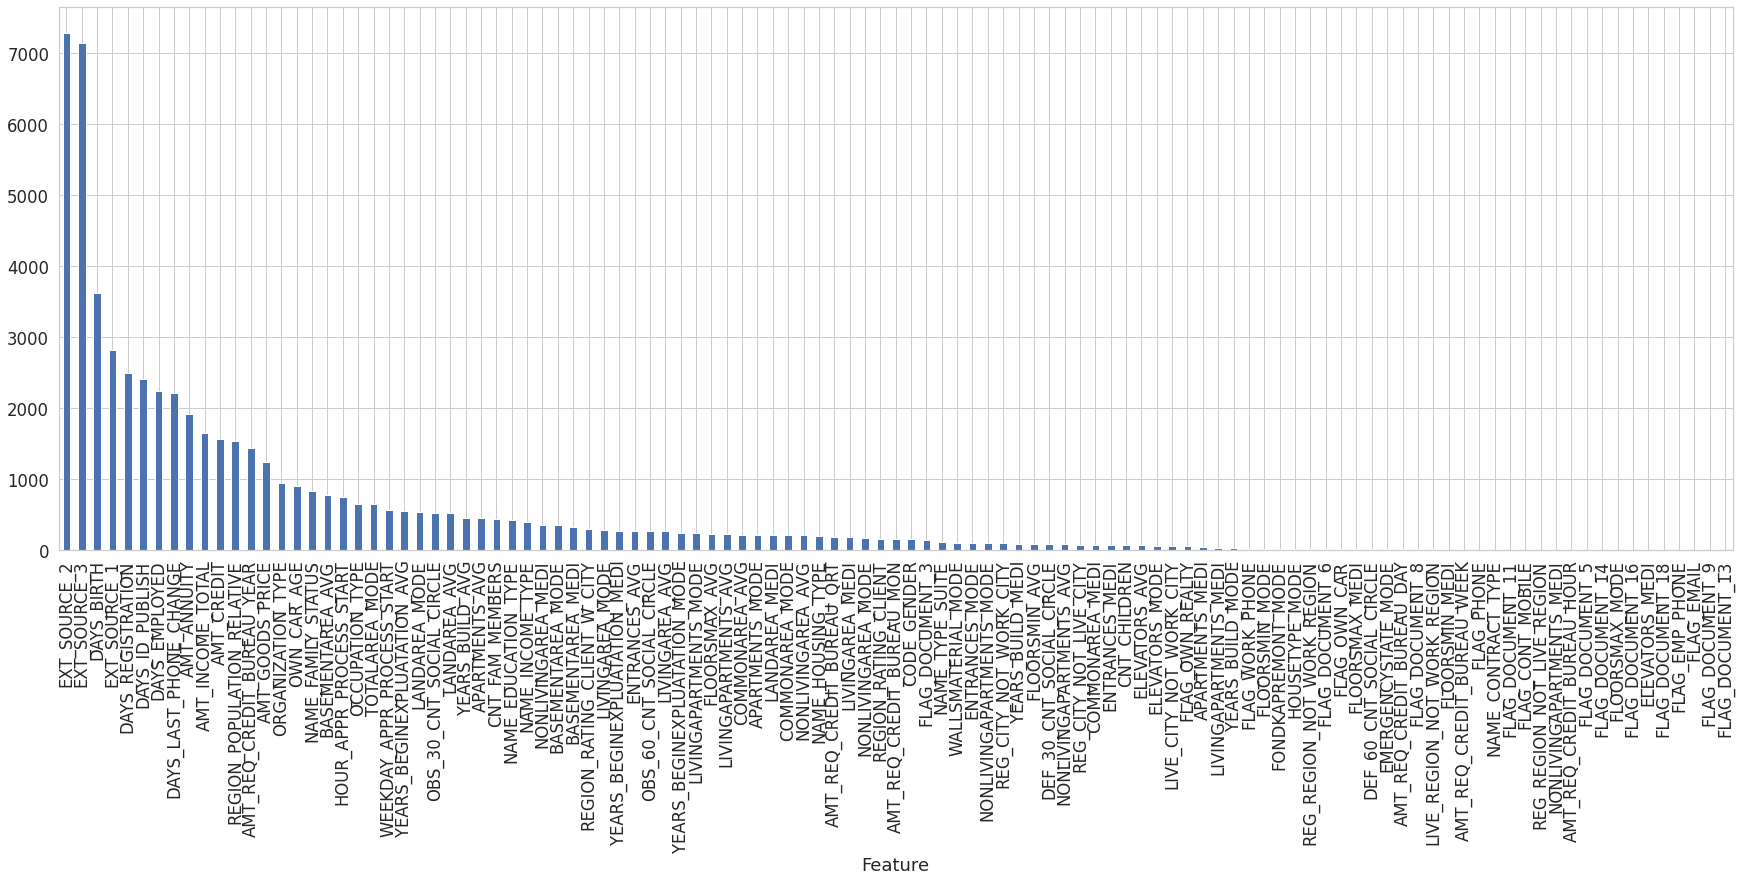

In [ ]:
%%time

# Fast feature importances calculation
fast_fi = automl_rd.model.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [ ]:
%%time

# Accurate feature importances calculation with detailed info (Permutation importances) -  can take long time to calculate
accurate_fi = automl_rd.model.get_feature_scores('accurate', te_data, silent = False)

INFO3:lightautoml.automl.presets.utils:LightAutoML ts master used 109 feats
INFO3:lightautoml.automl.presets.utils:1/109 Calculated score for FLOORSMIN_MODE: 0.0002887
INFO3:lightautoml.automl.presets.utils:2/109 Calculated score for COMMONAREA_AVG: -0.0013723
INFO3:lightautoml.automl.presets.utils:3/109 Calculated score for FLAG_EMP_PHONE: -0.0002106
INFO3:lightautoml.automl.presets.utils:4/109 Calculated score for APARTMENTS_AVG: -0.0009409
INFO3:lightautoml.automl.presets.utils:5/109 Calculated score for LANDAREA_MODE: 0.0004857
INFO3:lightautoml.automl.presets.utils:6/109 Calculated score for COMMONAREA_MEDI: 0.0001019
INFO3:lightautoml.automl.presets.utils:7/109 Calculated score for FLAG_DOCUMENT_6: -0.0001189
INFO3:lightautoml.automl.presets.utils:8/109 Calculated score for LIVINGAPARTMENTS_MODE: 0.0021094
INFO3:lightautoml.automl.presets.utils:9/109 Calculated score for NONLIVINGAPARTMENTS_AVG: 0.0003770
INFO3:lightautoml.automl.presets.utils:10/109 Calculated score for FLOORSMA

CPU times: user 1min 42s, sys: 1.12 s, total: 1min 43s
Wall time: 1min 17s


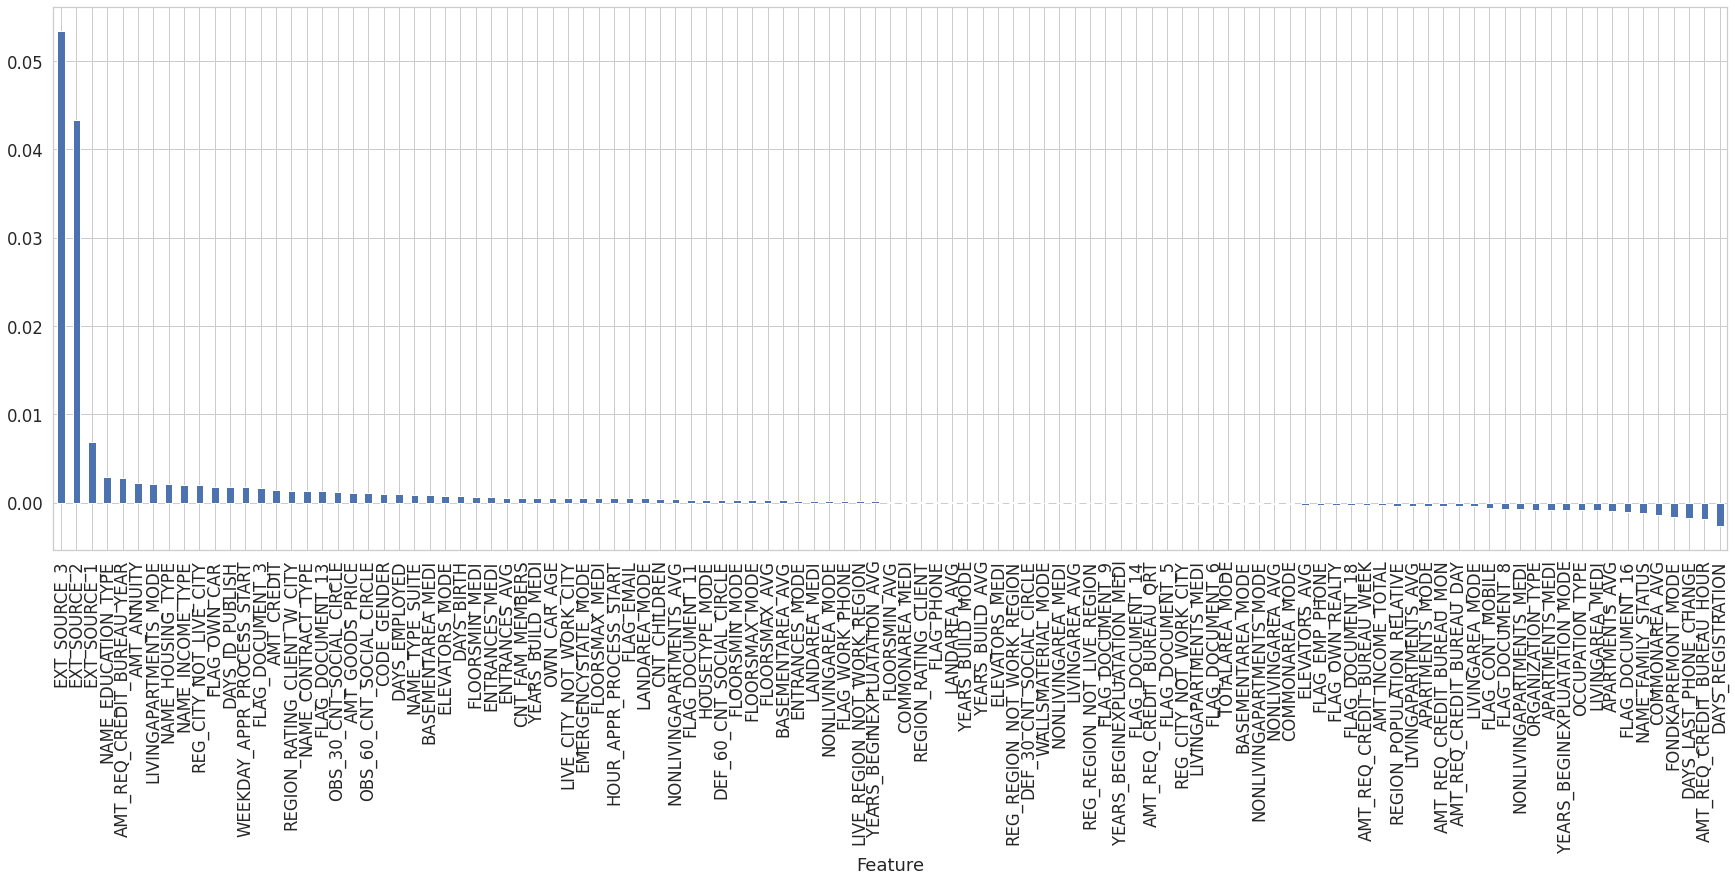

In [ ]:
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

### Bonus: where is the automatic report?


As we used `automl_rd` in our training and prediction cells, it is already ready in the folder we specified - you can check the output folder and find the `tabularAutoML_model_report` folder with `lama_interactive_report.html` report inside (or just [click this link](tabularAutoML_model_report/lama_interactive_report.html) for short). It's interactive so you can click the black triangles on the left of the texts to go deeper in selected part.

## 5. Spending more from TIMEOUT - `TabularUtilizedAutoML` usage

To spend (almost) all the `TIMEOUT` time for building the model we can use `TabularUtilizedAutoML` preset instead of `TabularAutoML`, which has the same API. By default ```TabularUtilizedAutoML``` model trains with 7 different parameter configurations (see [this](https://github.com/sb-ai-lab/LightAutoML/tree/master/lightautoml/automl/presets/tabular_configs) for more details) sequentially, and if there is time left, then whole AutoML pipeline with these configs is run again with another cross-validation seed, and so on. Then results for each pipeline model are averaged over the considered validation seeds, and all averaged results at the end are also combined through blending. User can set his own set of configs by passing list of paths to according files in ```configs_list``` argument during ```TabularUtilizedAutoML``` instance initialization. Such configs allow the user to configure all pipeline parameters and can be used for any available preset. 

In [ ]:
utilized_automl = TabularUtilizedAutoML(
    task = task, 
    timeout = 900,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)

In [ ]:
%%time 

oof_pred = utilized_automl.fit_predict(tr_data, roles = roles, verbose = 4)

[08:34:46] Start automl utilizator with listed constraints:


INFO:lightautoml.addons.utilization.utilization:Start automl utilizator with listed constraints:


[08:34:46] - time: 900.00 seconds


INFO:lightautoml.addons.utilization.utilization:- time: 900.00 seconds


[08:34:46] - CPU: 4 cores


INFO:lightautoml.addons.utilization.utilization:- CPU: 4 cores


[08:34:46] - memory: 16 GB



INFO:lightautoml.addons.utilization.utilization:- memory: 16 GB



[08:34:46] If one preset completes earlier, next preset configuration will be started



INFO:lightautoml.addons.utilization.utilization:If one preset completes earlier, next preset configuration will be started



[08:34:46] ==================================================


INFO:lightautoml.addons.utilization.utilization:==================================================


[08:34:46] Start 0 automl preset configuration:


INFO:lightautoml.addons.utilization.utilization:Start 0 automl preset configuration:


[08:34:46] conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}


INFO:lightautoml.addons.utilization.utilization:conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
INFO3:lightautoml.addons.utilization.utilization:Found reader_params in kwargs, need to combine
INFO3:lightautoml.addons.utilization.utilization:Merged variant for reader_params = {'n_jobs': 4, 'cv': 5, 'random_state': 42}


[08:34:46] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[08:34:46] Task: binary



INFO:lightautoml.automl.presets.base:Task: binary



[08:34:46] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[08:34:46] - time: 899.99 seconds


INFO:lightautoml.automl.presets.base:- time: 899.99 seconds


[08:34:46] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[08:34:46] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[08:34:46] Train data shape: (8000, 122)



INFO:lightautoml.reader.base:Train data shape: (8000, 122)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[08:34:51] Layer 1 train process start. Time left 894.85 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 894.85 secs


[08:34:52] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183], 'embed_sizes': array([20,  8,  9,  3,  5,  6,  3,  9,  3,  6,  6, 10,  3,  6,  8,  3],
      dtype=int32), 'data_size': 184}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.6793490172180616
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.700987860224193
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.7198550283047612
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear 

[08:35:00] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.735446338918961


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.735446338918961


[08:35:00] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[08:35:00] Time left 885.61 secs



INFO:lightautoml.automl.base:Time left 885.61 secs



[08:35:01] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 32, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 0.5, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.750084
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.757445
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.756729
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.757958
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	

[08:35:48] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.7426616484670829


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.7426616484670829


[08:35:48] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[08:35:48] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 41.81 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 41.81 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-b77e8eb5-43bf-4b72-9c0a-85203eb73700
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.738736
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.744092
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.747983
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.750469
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.752388
DEBUG:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.752634
DEBUG:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.750549
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[571]	valid's auc: 0.753757
INFO:optuna.study.study:Trial 0 finished with value: 0.7537565950895649 and parameters

[08:36:39] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'bagging_fraction': 0.5909124836035503, 'min_sum_hessian_in_leaf': 0.00541524411940254, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323}
 achieve 0.7569 auc


[08:36:39] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 66, 'feature_fraction': 0.9162213204002109, 'bagging_fraction': 0.5909124836035503, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 100, 'random_state': 42, 'min_sum_hessian_in_leaf': 0.00541524411940254}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.749475
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.743889
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stoppi

[08:37:07] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.6853603317743409


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.6853603317743409


[08:37:07] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


[08:37:07] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 5000, 'learning_rate': 0.035, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6212294	best: 0.6212294 (0)	total: 7.31ms	remaining: 36.6s
DEBUG:lightautoml.ml_algo.boost_cb:100:	test: 0.7243720	best: 0.7256657 (89)	total: 614ms	remaining: 29.8s
DEBUG:lightautoml.ml_algo.boost_cb:200:	test: 0.7314709	best: 0.7325507 (183)

[08:37:20] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.7158152161318831


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.7158152161318831


[08:37:20] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[08:37:20] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-d49489b3-c86f-48ac-83a3-25a58aa26994
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.5806058	best: 0.5806058 (0)	total: 5.16ms	remaining: 25.8s
DEBUG:lightautoml.ml_algo.boost_cb:100:	test: 0.7388264	best: 0.7388264 (100)	total: 472ms	remaining: 22.9s
DEBUG:lightautoml.ml_algo.boost_cb:200:	test: 0.7444660	best: 0.7458452 (197)	total: 951ms	remaining: 22.7s
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.7458451604
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 197
INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 198 iterations.
INFO:optuna.study.study:Trial 0 finished with value: 0.7458451603936473 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.

[08:41:14] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.4671276804481113, 'min_data_in_leaf': 20}
 achieve 0.7707 auc


[08:41:14] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 3.4671276804481113, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'min_data_in_leaf': 20, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Max', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.5885706	best: 0.5885706 (0)	total: 7.52ms	remaining: 22.6s
DEBUG:lightautoml.ml_algo.boost_cb:100:	test: 0.7564026	best: 0.7568249 (97)	total: 810ms	remaining: 23.2s
DEBUG:lightautoml.ml_algo.boost_cb:200:	test: 0.761

[08:41:27] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.7418767309588941


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.7418767309588941


[08:41:27] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


[08:41:27] Time left 498.63 secs



INFO:lightautoml.automl.base:Time left 498.63 secs



[08:41:27] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[08:41:27] Blending: optimization starts with equal weights and score 0.748317221477061


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights and score 0.748317221477061


[08:41:27] Blending: iteration 0: score = 0.7513775918807384, weights = [0.23249884 0.4219817  0.         0.         0.34551948]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = 0.7513775918807384, weights = [0.23249884 0.4219817  0.         0.         0.34551948]


[08:41:28] Blending: iteration 1: score = 0.7517817436096298, weights = [0.243905   0.32364315 0.07014852 0.         0.3623033 ]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = 0.7517817436096298, weights = [0.243905   0.32364315 0.07014852 0.         0.3623033 ]


[08:41:28] Blending: iteration 2: score = 0.7517838696050474, weights = [0.2664187  0.3140063  0.06805976 0.         0.35151526]


INFO:lightautoml.automl.blend:Blending: iteration 2: score = 0.7517838696050474, weights = [0.2664187  0.3140063  0.06805976 0.         0.35151526]


[08:41:28] Blending: iteration 3: score = 0.7517838696050474, weights = [0.2664187  0.3140063  0.06805976 0.         0.35151526]


INFO:lightautoml.automl.blend:Blending: iteration 3: score = 0.7517838696050474, weights = [0.2664187  0.3140063  0.06805976 0.         0.35151526]


[08:41:28] Blending: no score update. Terminated



INFO:lightautoml.automl.blend:Blending: no score update. Terminated



[08:41:28] Automl preset training completed in 402.03 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 402.03 seconds



[08:41:28] Model description:
Final prediction for new objects (level 0) = 
	 0.26642 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.31401 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.06806 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.35152 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 0.26642 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.31401 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.06806 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.35152 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 



[08:41:28] ==================================================


INFO:lightautoml.addons.utilization.utilization:==================================================


[08:41:28] Start 1 automl preset configuration:


INFO:lightautoml.addons.utilization.utilization:Start 1 automl preset configuration:


[08:41:28] conf_1_sel_type_1.yml, random state: {'reader_params': {'random_state': 43}, 'general_params': {'return_all_predictions': False}}


INFO:lightautoml.addons.utilization.utilization:conf_1_sel_type_1.yml, random state: {'reader_params': {'random_state': 43}, 'general_params': {'return_all_predictions': False}}
INFO3:lightautoml.addons.utilization.utilization:Found reader_params in kwargs, need to combine
INFO3:lightautoml.addons.utilization.utilization:Merged variant for reader_params = {'n_jobs': 4, 'cv': 5, 'random_state': 43}


[08:41:28] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[08:41:28] Task: binary



INFO:lightautoml.automl.presets.base:Task: binary



[08:41:28] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[08:41:28] - time: 497.87 seconds


INFO:lightautoml.automl.presets.base:- time: 497.87 seconds


[08:41:28] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[08:41:28] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[08:41:28] Train data shape: (8000, 122)



INFO:lightautoml.reader.base:Train data shape: (8000, 122)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[08:41:33] Layer 1 train process start. Time left 492.81 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 492.81 secs


[08:41:34] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179], 'embed_sizes': array([20,  8,  5,  5,  6,  3,  9,  3,  6,  6, 10], dtype=int32), 'data_size': 180}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.6588193787385538
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.6791111396207857
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.6910477839964506
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = 0.7243132286671905
INFO3

[08:41:42] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7337655269417833


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7337655269417833


[08:41:42] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[08:41:42] Time left 483.67 secs



INFO:lightautoml.automl.base:Time left 483.67 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.713494
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.719021
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.724297
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.725735
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.726345
DEBUG:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.725163
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[469]	valid's auc: 0.72798


[08:41:54] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[08:41:55] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 32, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 0.5, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.732417
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.748149
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.750164
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.748807
DEBUG:lightautoml.ml_algo.boost_lgbm:Early 

[08:42:31] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.723332735928621


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.723332735928621


[08:42:31] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[08:42:31] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1.00 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-8e6a594a-a6b0-4b9e-89ea-753f11aecb32
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.735635
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.738987
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.741825
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.739869
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.736319
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[312]	valid's auc: 0.742718
INFO:optuna.study.study:Trial 0 finished with value: 0.7427180054631664 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.

[08:42:54] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}
 achieve 0.7427 auc


[08:42:54] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 244, 'feature_fraction': 0.6872700594236812, 'bagging_fraction': 0.8659969709057025, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 100, 'random_state': 42, 'min_sum_hessian_in_leaf': 0.24810409748678125}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.739147
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[84]	valid's auc: 0.74105
INFO2:light

[08:43:35] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.6763036975950102


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.6763036975950102


[08:43:35] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


[08:43:36] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 5000, 'learning_rate': 0.035, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.5279226	best: 0.5279226 (0)	total: 6.94ms	remaining: 34.7s
DEBUG:lightautoml.ml_algo.boost_cb:100:	test: 0.7128791	best: 0.7128791 (100)	total: 632ms	remaining: 30.6s
DEBUG:lightautoml.ml_algo.boost_cb:200:	test: 0.7100673	best: 0.7154342 (104

[08:43:47] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.69953838261497


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.69953838261497


[08:43:47] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[08:43:47] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 195.55 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 195.55 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-648d65a1-3f3b-4945-9f2a-25c736d370fe
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.5396561	best: 0.5396561 (0)	total: 5.59ms	remaining: 27.9s
DEBUG:lightautoml.ml_algo.boost_cb:100:	test: 0.7142850	best: 0.7151990 (73)	total: 499ms	remaining: 24.2s
DEBUG:lightautoml.ml_algo.boost_cb:200:	test: 0.7238589	best: 0.7249975 (194)	total: 992ms	remaining: 23.7s
DEBUG:lightautoml.ml_algo.boost_cb:300:	test: 0.7210311	best: 0.7258100 (216)	total: 1.47s	remaining: 22.9s
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.7258099866
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 216
INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 217 iterations.
INFO:optuna.study.study:Trial 0 fi

[08:47:04] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.527156759251193, 'min_data_in_leaf': 6}
 achieve 0.7428 auc


[08:47:04] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 1.527156759251193, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 3, 'min_data_in_leaf': 6, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Max', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.5377557	best: 0.5377557 (0)	total: 4.15ms	remaining: 12.4s
DEBUG:lightautoml.ml_algo.boost_cb:100:	test: 0.7125102	best: 0.7125102 (100)	total: 413ms	remaining: 11.8s
DEBUG:lightautoml.ml_algo.boost_cb:200:	test: 0.7190

[08:47:18] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.7377284887000155


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.7377284887000155


[08:47:18] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


[08:47:18] Time left 147.47 secs



INFO:lightautoml.automl.base:Time left 147.47 secs



[08:47:18] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[08:47:18] Blending: optimization starts with equal weights and score 0.746032839400818


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights and score 0.746032839400818


[08:47:19] Blending: iteration 0: score = 0.7475622805042605, weights = [0.26987976 0.2519153  0.09224582 0.12176806 0.26419103]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = 0.7475622805042605, weights = [0.26987976 0.2519153  0.09224582 0.12176806 0.26419103]


[08:47:19] Blending: iteration 1: score = 0.7476005484217778, weights = [0.2900545  0.25415003 0.0852972  0.11259563 0.2579027 ]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = 0.7476005484217778, weights = [0.2900545  0.25415003 0.0852972  0.11259563 0.2579027 ]


[08:47:19] Blending: iteration 2: score = 0.7476307375567083, weights = [0.28870457 0.24263683 0.07967807 0.10517816 0.28380233]


INFO:lightautoml.automl.blend:Blending: iteration 2: score = 0.7476307375567083, weights = [0.28870457 0.24263683 0.07967807 0.10517816 0.28380233]


[08:47:19] Blending: iteration 3: score = 0.747636477744336, weights = [0.28983894 0.24359022 0.07999114 0.09401332 0.2925664 ]


INFO:lightautoml.automl.blend:Blending: iteration 3: score = 0.747636477744336, weights = [0.28983894 0.24359022 0.07999114 0.09401332 0.2925664 ]


[08:47:19] Blending: iteration 4: score = 0.7476349895475436, weights = [0.2896547  0.2430592  0.07994029 0.09496545 0.2923804 ]


INFO:lightautoml.automl.blend:Blending: iteration 4: score = 0.7476349895475436, weights = [0.2896547  0.2430592  0.07994029 0.09496545 0.2923804 ]


[08:47:19] Automl preset training completed in 351.36 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 351.36 seconds



[08:47:19] Model description:
Final prediction for new objects (level 0) = 
	 0.28965 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.24306 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.07994 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.09497 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.29238 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 0.28965 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.24306 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.07994 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.09497 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.29238 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 



[08:47:19] ==================================================


INFO:lightautoml.addons.utilization.utilization:==================================================


[08:47:19] Blending: optimization starts with equal weights and score 0.7525220152140486


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights and score 0.7525220152140486


[08:47:19] Blending: iteration 0: score = 0.752881202139857, weights = [0.618034   0.38196602]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = 0.752881202139857, weights = [0.618034   0.38196602]


[08:47:20] Blending: iteration 1: score = 0.752881202139857, weights = [0.618034   0.38196602]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = 0.752881202139857, weights = [0.618034   0.38196602]


[08:47:20] Blending: no score update. Terminated



INFO:lightautoml.automl.blend:Blending: no score update. Terminated



CPU times: user 21min 22s, sys: 54.7 s, total: 22min 17s
Wall time: 12min 33s


In [ ]:
print('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

oof_pred:
array([[0.04348096],
       [0.02140103],
       [0.03235983],
       ...,
       [0.02801539],
       [0.1958406 ],
       [0.10697322]], dtype=float32)
Shape = (8000, 1)


In [ ]:
print(utilized_automl.create_model_str_desc())

Final prediction for new objects = 
	0.61803 * 1 averaged models with config = "conf_0_sel_type_0.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.26642 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
			 0.31401 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
			 0.06806 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
			 0.35152 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


	+ 0.38197 * 1 averaged models with config = "conf_1_sel_type_1.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.28965 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
			 0.24306 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
			 0.07994 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
			 0.09497 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
			 0.29238 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost)

Feature importances calculation for `TabularUtilizedAutoML`:

CPU times: user 199 ms, sys: 0 ns, total: 199 ms
Wall time: 203 ms


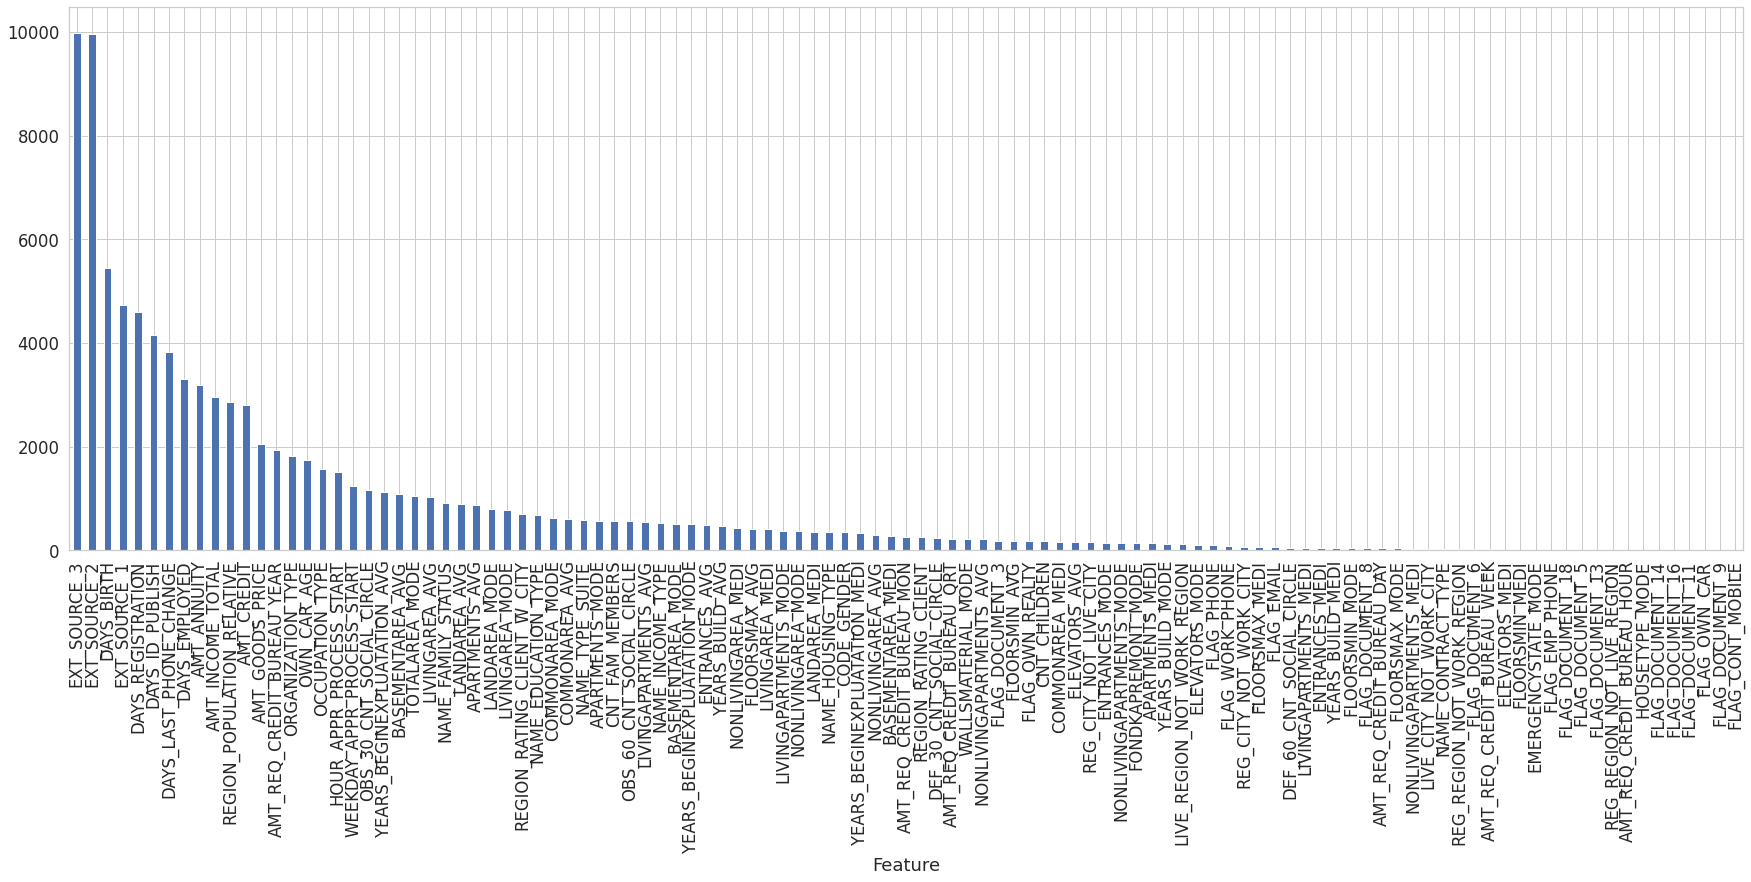

In [ ]:
%%time

# Fast feature importances calculation
fast_fi = utilized_automl.get_feature_scores('fast', silent=False)
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

Note that in ```TabularUtilizedAutoML``` the first config doesn't have a LGBM feature selector (but second one already has it), so if there is enough time only for training with the first config, then ```'fast'``` feature importance calculation method won't work. ```'accurate'``` method will still work correctly.

INFO3:lightautoml.automl.presets.utils:LightAutoML ts master used 109 feats
INFO3:lightautoml.automl.presets.utils:1/109 Calculated score for COMMONAREA_AVG: -0.0026189
INFO3:lightautoml.automl.presets.utils:2/109 Calculated score for FLOORSMIN_MODE: 0.0007439
INFO3:lightautoml.automl.presets.utils:3/109 Calculated score for FLAG_EMP_PHONE: -0.0000272
INFO3:lightautoml.automl.presets.utils:4/109 Calculated score for LANDAREA_MODE: 0.0012466
INFO3:lightautoml.automl.presets.utils:5/109 Calculated score for APARTMENTS_AVG: -0.0004110
INFO3:lightautoml.automl.presets.utils:6/109 Calculated score for COMMONAREA_MEDI: -0.0004789
INFO3:lightautoml.automl.presets.utils:7/109 Calculated score for FLAG_DOCUMENT_6: -0.0002548
INFO3:lightautoml.automl.presets.utils:8/109 Calculated score for LIVINGAPARTMENTS_MODE: -0.0023098
INFO3:lightautoml.automl.presets.utils:9/109 Calculated score for NONLIVINGAPARTMENTS_AVG: 0.0000068
INFO3:lightautoml.automl.presets.utils:10/109 Calculated score for FLOORS

CPU times: user 5min 19s, sys: 2.89 s, total: 5min 21s
Wall time: 3min 44s


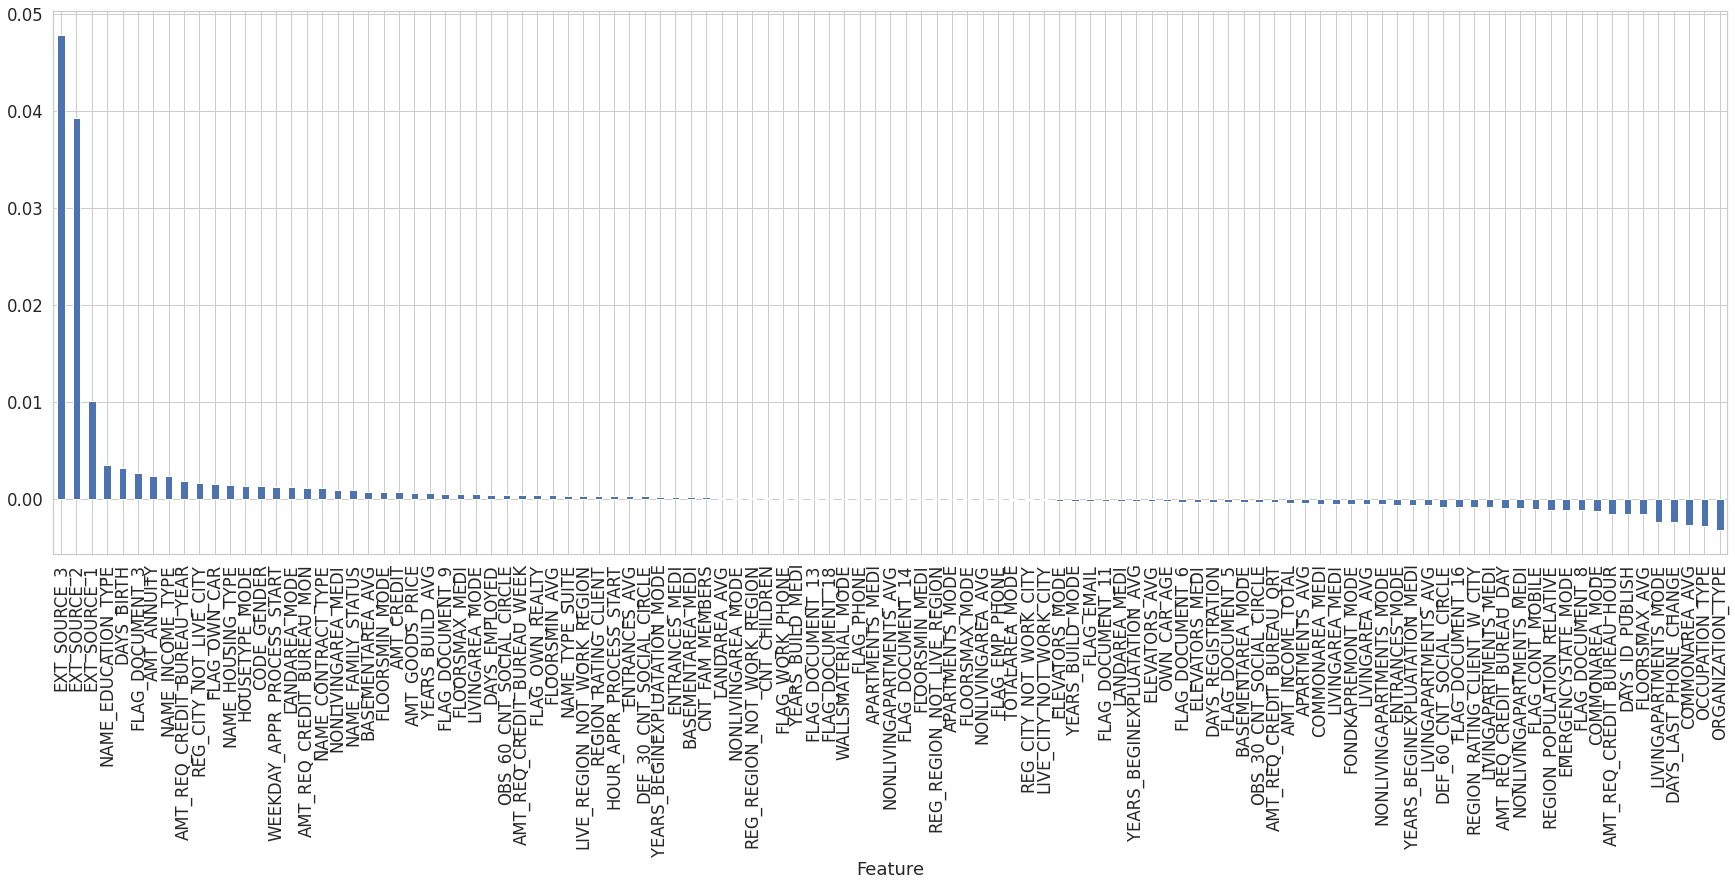

In [ ]:
%%time

# Accurate feature importances calculation
fast_fi = utilized_automl.get_feature_scores('accurate', te_data, silent=False)
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

Prediction on holdout and metric calculation:

In [ ]:
%%time

te_pred = utilized_automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[0.06636593],
       [0.0759781 ],
       [0.0329283 ],
       ...,
       [0.06612222],
       [0.044288  ],
       [0.20196399]], dtype=float32)
Shape = (2000, 1)
CPU times: user 2.82 s, sys: 23.7 ms, total: 2.84 s
Wall time: 1.93 s


In [ ]:
print(f'OOF score: {roc_auc_score(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])}')
print(f'HOLDOUT score: {roc_auc_score(te_data[TARGET_NAME].values, te_pred.data[:, 0])}')

OOF score: 0.752881202139857
HOLDOUT score: 0.7328158967391305


It is also important to note that using a ```ReportDeco``` decorator for a ```TabularUtilizedAutoML``` is not yet available.

## Bonus: another tasks examples

### Regression task

Without big differences from the case of binary classification, LightAutoML can solve the regression problems.

Load the data, split it into train and validation parts:

In [ ]:
DATASET_NAME = 'train.csv'
DATASET_FULLNAME = os.path.join(DATASET_DIR, 'train.csv')

DATASET_URL = 'https://raw.githubusercontent.com/reneemarama/aiming_high_in_aimes/master/datasets/train.csv'

if not os.path.exists(DATASET_FULLNAME):
    os.makedirs(DATASET_DIR, exist_ok=True)

    dataset = requests.get(DATASET_URL).text
    with open(DATASET_FULLNAME, 'w') as output:
        output.write(dataset)

In [ ]:
data = pd.read_csv('./data/train.csv')
data.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [ ]:
data.shape

(2051, 81)

In [ ]:
tr_data, te_data = train_test_split(
    data, 
    test_size=TEST_SIZE,  
    random_state=RANDOM_STATE
)

print(f'Data is splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')

tr_data.head()

Data is splitted. Parts sizes: tr_data = (1640, 81), te_data = (411, 81)


,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
1448,452,528174050,120,RL,47.0,6904,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,8,2009,WD,213000
1771,1697,528110070,20,RL,110.0,14226,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,7,2007,New,395000
966,2294,923229100,80,RL,NaN,15957,Pave,NaN,IR1,Low,...,0,0,NaN,MnPrv,NaN,0,9,2007,WD,188000
1604,2449,528348010,60,RL,93.0,12090,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,7,2006,WD,258000
1827,1859,533254100,80,RL,80.0,9600,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,8,2007,WD,187000


Now we have a regression task, and it is necessary to specify it in ```Task``` object. Note that default loss and metric for regression task is MSE, but you can use any available functions, for example, MAE:

In [ ]:
task = Task('reg', loss='mae', metric='mae')

Specifying columns roles:

In [ ]:
roles = {
    'target': 'SalePrice',
    'drop': ['Id', 'PID']
}

Building AutoML model:

In [ ]:
automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

Training:

In [ ]:
%%time 
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 4)

[11:55:38] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[11:55:38] Task: reg



INFO:lightautoml.automl.presets.base:Task: reg



[11:55:38] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[11:55:38] - time: 300.00 seconds


INFO:lightautoml.automl.presets.base:- time: 300.00 seconds


[11:55:38] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[11:55:38] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[11:55:38] Train data shape: (1640, 81)



INFO:lightautoml.reader.base:Train data shape: (1640, 81)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[11:55:41] Layer 1 train process start. Time left 297.13 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 297.13 secs


[11:55:41] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101], 'embed_sizes': array([ 2,  3,  5, 15,  3,  4,  4,  5,  4, 11,  6,  6,  7, 13,  9,  6,  8,
        3,  3,  5,  8,  2,  5,  5,  6,  5, 26,  8,  6,  5,  8],
      dtype=int32), 'data_size': 102}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = -183094.6444520934
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = -57326.21551067073
INFO3:lightautoml.ml_algo.torch_based.linear_mo

[11:55:57] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -15985.46386599657


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -15985.46386599657


[11:55:57] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[11:55:57] Time left 280.91 secs



INFO:lightautoml.automl.base:Time left 280.91 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's l1: 32745.5
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's l1: 22990.8
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's l1: 18795.6
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's l1: 16863.3
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	valid's l1: 16181.7
DEBUG:lightautoml.ml_algo.boost_lgbm:[600]	valid's l1: 15843
DEBUG:lightautoml.ml_algo.boost_lgbm:[700]	valid's l1: 15624.5
DEBUG:lightautoml.ml_algo.boost_lgbm:[800]	valid's l1: 15421.2
DEBUG:lightautoml.ml_algo.boost_lgbm:[900]	valid's l1: 15210.7
DEBUG:lightautoml.ml_algo.boost_lgbm:[1000]	valid's l1: 15092.2
DEBUG:lightautoml.ml_algo.boost_lgbm:[1100]	valid's l1: 15007.2
DEBUG:lightautoml.ml_algo.boost_lgbm:[1200]	valid's l1: 14920
DEBUG:lightautoml.ml_algo.boost_lgbm:[1300]	valid's l1: 14865
DEBUG:lightautoml.ml_algo.boost_

[11:56:05] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[11:56:05] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's l1: 33218.3
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's l1: 23373.6
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's l1: 19268.8
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's l1: 17503.2
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	valid's l1

[11:56:26] Time limit exceeded after calculating fold 1



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 1



[11:56:26] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -15196.038002572408


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -15196.038002572408


[11:56:26] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[11:56:26] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1.00 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-bba814f8-017a-4da5-893e-dd51c5cccee4
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's l1: 32081
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's l1: 22135
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's l1: 18562.6
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's l1: 17334.9
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	valid's l1: 16730.3
DEBUG:lightautoml.ml_algo.boost_lgbm:[600]	valid's l1: 16387.9
DEBUG:lightautoml.ml_algo.boost_lgbm:[700]	valid's l1: 16200.9
DEBUG:lightautoml.ml_algo.boost_lgbm:[800]	valid's l1: 16013.9
DEBUG:lightautoml.ml_algo.boost_lgbm:[900]	valid's l1: 15901.4
DEBUG:lightautoml.ml_algo.boost_lgbm:[1000]	valid's l1: 15850
DEBUG:lightautoml

[11:56:38] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}
 achieve -15221.1919 mae


[11:56:38] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 244, 'feature_fraction': 0.6872700594236812, 'bagging_fraction': 0.8659969709057025, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 100, 'random_state': 42, 'min_sum_hessian_in_leaf': 0.24810409748678125}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's l1: 17075.7
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's l1: 16127.3
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid

[11:57:03] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -15111.560423018293


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -15111.560423018293


[11:57:03] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


[11:57:03] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 2000, 'learning_rate': 0.05, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 300, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 54278.8462766	test: 55648.8059194	best: 55648.8059194 (0)	total: 2.15ms	remaining: 4.29s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 15042.1208375	test: 18252.2032759	best: 18252.2032759 (100)	total: 187ms	remaining: 3.52s
DEBUG:lightautoml.m

[11:57:24] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -14560.22733898628


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -14560.22733898628


[11:57:24] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[11:57:24] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 58.48 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 58.48 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-9eb27ab2-5f13-4974-9b7a-a6d3798c5113
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 54199.5043549	test: 55605.4024128	best: 55605.4024128 (0)	total: 1.54ms	remaining: 3.08s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 16336.7751464	test: 19360.1761477	best: 19360.1761477 (100)	total: 146ms	remaining: 2.74s
DEBUG:lightautoml.ml_algo.boost_cb:200:	learn: 12946.1216279	test: 17162.5936823	best: 17162.5936823 (200)	total: 292ms	remaining: 2.61s
DEBUG:lightautoml.ml_algo.boost_cb:300:	learn: 11454.8962871	test: 16548.4522210	best: 16548.4522210 (300)	total: 430ms	remaining: 2.43s
DEBUG:lightautoml.ml_algo.boost_cb:400:	learn: 10484.9728585	test: 16138.2806351	best: 16138.2806351 (400)	total: 566ms	remaining: 2.25s
DEBUG:lightautoml.ml_algo.boost_cb:500:	learn: 9764.982492

[11:58:24] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 1.3815073407783126e-08, 'min_data_in_leaf': 13}
 achieve -15040.6949 mae


[11:58:24] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 1.3815073407783126e-08, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 13, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 54972.8510971	test: 56313.8860275	best: 56313.8860275 (0)	total: 2.06ms	remaining: 6.17s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 18333.1340962	test: 21050.4183139	best: 21050.4183139 (100)	total: 191ms	remai

[11:58:42] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -14688.600176257622


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -14688.600176257622


[11:58:42] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


[11:58:42] Time left 116.58 secs



INFO:lightautoml.automl.base:Time left 116.58 secs



[11:58:42] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



INFO:lightautoml.automl.base:Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



[11:58:42] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[11:58:42] Blending: optimization starts with equal weights and score -14113.578358422255


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights and score -14113.578358422255


[11:58:42] Blending: iteration 0: score = -14089.623301733995, weights = [0.24851108 0.13000134 0.16410585 0.33718854 0.12019318]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = -14089.623301733995, weights = [0.24851108 0.13000134 0.16410585 0.33718854 0.12019318]


[11:58:42] Blending: iteration 1: score = -14085.514041063263, weights = [0.25393552 0.06316131 0.1676879  0.4178023  0.09741296]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = -14085.514041063263, weights = [0.25393552 0.06316131 0.1676879  0.4178023  0.09741296]


[11:58:42] Blending: iteration 2: score = -14084.858143578505, weights = [0.26686746 0.         0.18183662 0.4530545  0.09824143]


INFO:lightautoml.automl.blend:Blending: iteration 2: score = -14084.858143578505, weights = [0.26686746 0.         0.18183662 0.4530545  0.09824143]


[11:58:42] Blending: iteration 3: score = -14084.858143578505, weights = [0.26686746 0.         0.18183662 0.4530545  0.09824143]


INFO:lightautoml.automl.blend:Blending: iteration 3: score = -14084.858143578505, weights = [0.26686746 0.         0.18183662 0.4530545  0.09824143]


[11:58:42] Blending: no score update. Terminated



INFO:lightautoml.automl.blend:Blending: no score update. Terminated



[11:58:42] Automl preset training completed in 183.61 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 183.61 seconds



[11:58:42] Model description:
Final prediction for new objects (level 0) = 
	 0.26687 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.18184 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.45305 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.09824 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 0.26687 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.18184 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.45305 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.09824 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 



CPU times: user 5min 17s, sys: 12.7 s, total: 5min 29s
Wall time: 3min 3s


In [ ]:
%%time

te_pred = automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[134238.16 ],
       [211568.31 ],
       [273346.3  ],
       [128712.3  ],
       [200011.81 ],
       [386086.4  ],
       [157955.89 ],
       [288234.6  ],
       [159803.36 ],
       [ 87193.1  ],
       [139517.72 ],
       [216178.02 ],
       [164734.31 ],
       [111740.07 ],
       [115553.734],
       [105156.95 ],
       [ 98757.39 ],
       [205261.34 ],
       [329714.72 ],
       [233103.86 ],
       [211793.25 ],
       [193391.72 ],
       [138784.17 ],
       [126691.74 ],
       [154424.6  ],
       [252021.86 ],
       [164401.94 ],
       [139078.34 ],
       [260269.03 ],
       [112276.35 ],
       [338198.66 ],
       [119967.02 ],
       [124348.945],
       [167281.55 ],
       [196519.44 ],
       [ 98160.28 ],
       [174621.1  ],
       [232371.56 ],
       [385290.84 ],
       [113545.87 ],
       [257718.6  ],
       [192734.38 ],
       [313904.5  ],
       [188868.66 ],
       [ 81890.625],
       [156039.16 ],
       [12

In [ ]:
from sklearn.metrics import mean_absolute_error
print(f'OOF score: {mean_absolute_error(tr_data["SalePrice"].values, oof_pred.data[:, 0])}')
print(f'HOLDOUT score: {mean_absolute_error(te_data["SalePrice"].values, te_pred.data[:, 0])}')

OOF score: 14084.858143578505
HOLDOUT score: 12256.381510416666


In the same way as in the previous example with binary classification, you can build a detailed report using ```ReportDeco```, calculate feature importances, use ```TabularUtilizedAutoML``` etc.

### Multi-class classification

Now let's consider multi-class classification.  

Download and split the data:

In [ ]:
data = pd.read_csv('./Frogs_MFCCs.csv')
data.head()

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species,RecordID
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae,Adenomera,AdenomeraAndre,1
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae,Adenomera,AdenomeraAndre,1
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae,Adenomera,AdenomeraAndre,1
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae,Adenomera,AdenomeraAndre,1
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae,Adenomera,AdenomeraAndre,1


In [ ]:
tr_data, te_data = train_test_split(
    data, 
    test_size=TEST_SIZE, 
    stratify=data['Species'], 
    random_state=RANDOM_STATE
)

print(f'Data is splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')

tr_data.head()

Data is splitted. Parts sizes: tr_data = (5756, 26), te_data = (1439, 26)


,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species,RecordID
3839,1.0,0.508795,0.321659,0.540137,0.120548,-0.036063,-0.087857,0.075688,0.285572,0.105135,...,0.150806,-0.051546,-0.097560,-0.122970,-0.000077,0.162693,Leptodactylidae,Adenomera,AdenomeraHylaedactylus,22
4367,1.0,0.224528,0.274845,0.564590,0.235425,-0.049891,-0.194110,0.071205,0.304401,-0.032607,...,0.168676,-0.106362,-0.206512,-0.009765,0.187388,0.133031,Leptodactylidae,Adenomera,AdenomeraHylaedactylus,24
109,1.0,0.261617,0.050249,0.368280,0.411812,0.260813,-0.052358,-0.266545,-0.082652,0.385609,...,-0.154634,-0.134717,-0.065619,0.137002,0.220008,0.009936,Leptodactylidae,Adenomera,AdenomeraAndre,3
3685,1.0,0.558097,0.246345,0.475650,0.164136,0.041518,-0.054505,0.030449,0.237512,0.076564,...,0.197446,-0.004138,-0.089880,-0.132740,-0.003322,0.202557,Leptodactylidae,Adenomera,AdenomeraHylaedactylus,22
1957,1.0,0.523763,0.312842,0.641030,0.130073,-0.056040,-0.125987,0.136509,0.262649,-0.037006,...,0.236045,0.035403,-0.050994,-0.138909,-0.006350,0.133417,Leptodactylidae,Adenomera,AdenomeraHylaedactylus,17


Now we indicate that we have multi-class classification problem. Default metric and loss is cross-entropy function. 

In [ ]:
task = Task('multiclass')

Set the column roles, build and train AutoML model:

In [ ]:
roles = {
    'target': 'Species',
    'drop': ['RecordID']
}

In [ ]:
automl = TabularAutoML(
    task = task, 
    timeout = 900,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

Note that **in case of multi-class classification default pipeline architecture has a slightly different look**. First level is the same as level in default binary classification and regression, second level consists of linear regression and LightGBM model and the third is blending. It was decided to use two levels in default architecture based on the results of experiments on different tasks and data, where it gave an increase in model quality. Intuitively, this can be explained by the fact that only at the second and subsequent levels, the model that predicts the probability of belonging to one of the classes can see what the models that predict the rest of the classes see, that is, the models are able to exchange information about classes. Final prediction is blended from last pipeline level. 

In [ ]:
%%time 
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 4)

[07:55:24] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[07:55:24] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer


[07:55:24] Task: multiclass



INFO:lightautoml.automl.presets.base:Task: multiclass



[07:55:24] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[07:55:24] - time: 900.00 seconds


INFO:lightautoml.automl.presets.base:- time: 900.00 seconds


[07:55:24] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[07:55:24] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[07:55:24] Train data shape: (5756, 26)



INFO:lightautoml.reader.base:Train data shape: (5756, 26)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[07:55:28] Layer 1 train process start. Time left 896.86 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 896.86 secs


[07:55:28] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [22, 23, 24, 25], 'embed_sizes': array([ 5,  9,  9, 11], dtype=int32), 'data_size': 26}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = -1.503498690409793
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = -1.1660977623929891
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = -0.9724527337497825
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = -0.5284304930335364
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0

[07:55:45] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.007838240046585171


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.007838240046585171


[07:55:45] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[07:55:45] Time left 879.26 secs



INFO:lightautoml.automl.base:Time left 879.26 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 0.459231
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's multi_logloss: 0.178704
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's multi_logloss: 0.0785291
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's multi_logloss: 0.0388528
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	valid's multi_logloss: 0.0224836
DEBUG:lightautoml.ml_algo.boost_lgbm:[600]	valid's multi_logloss: 0.0157432
DEBUG:lightautoml.ml_algo.boost_lgbm:[700]	valid's multi_logloss: 0.0127719
DEBUG:lightautoml.ml_algo.boost_lgbm:[800]	valid's multi_logloss: 0.0113443
DEBUG:lightautoml.ml_algo.boost_lgbm:[900]	valid's multi_logloss: 0.0105996
DEBUG:lightautoml.ml_algo.boost_lgbm:[1000]	valid's multi_logloss: 0.0102278
DEBUG:lightautoml.ml_algo.boost_lgbm:[1100]	valid's multi_logloss: 0.00996021
DEBUG:lighta

[07:55:54] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[07:55:55] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 32, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 0.5, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 0.456337
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's multi_logloss: 0.174634
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's multi_logloss: 0.0740435
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's multi_logloss: 0.035269
DE

[07:56:40] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.008751480927829668


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.008751480927829668


[07:56:40] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[07:56:40] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 23.07 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 23.07 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-f59cd5d2-2ca4-40fb-8aa3-29fe64b11926
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 0.451331
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's multi_logloss: 0.169854
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's multi_logloss: 0.0693394
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's multi_logloss: 0.0310944
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	valid's multi_logloss: 0.0160326
DEBUG:lightautoml.ml_algo.boost_lgbm:[600]	valid's multi_logloss: 0.00990107
DEBUG:lightautoml.ml_algo.boost_lgbm:[700]	valid's multi_logloss: 0.00741715
DEBUG:lightautoml.ml_algo.boost_lgbm:[800]	valid's multi_logloss: 0.00649674
DEBUG:lightautoml.ml_algo.boost_

[07:57:12] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}
 achieve -0.0061 crossentropy


[07:57:12] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 244, 'feature_fraction': 0.6872700594236812, 'bagging_fraction': 0.8659969709057025, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 100, 'random_state': 42, 'min_sum_hessian_in_leaf': 0.24810409748678125}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 0.0159385
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's multi_logloss: 0.00629921
DEBUG:lightautoml.ml_

[07:57:32] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -0.0076667823949237044


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -0.0076667823949237044


[07:57:32] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


[07:57:32] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 2.0779889	test: 2.0777553	best: 2.0777553 (0)	total: 55.8ms	remaining: 2m 47s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 0.0748755	test: 0.0768651	best: 0.0768651 (100)	total: 714ms	remaining: 20.5s
DEBUG:lightautoml.ml_algo.boost_cb:200:	le

[07:58:16] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -0.004437219521172899


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -0.004437219521172899


[07:58:16] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[07:58:16] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 183.33 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 183.33 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-c73502d2-202b-49dc-b9e0-65cb4ec0db1d
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 2.1032564	test: 2.1049759	best: 2.1049759 (0)	total: 6.45ms	remaining: 19.3s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 0.1154378	test: 0.1163568	best: 0.1163568 (100)	total: 523ms	remaining: 15s
DEBUG:lightautoml.ml_algo.boost_cb:200:	learn: 0.0334010	test: 0.0333358	best: 0.0333358 (200)	total: 999ms	remaining: 13.9s
DEBUG:lightautoml.ml_algo.boost_cb:300:	learn: 0.0194354	test: 0.0199052	best: 0.0199052 (300)	total: 1.47s	remaining: 13.1s
DEBUG:lightautoml.ml_algo.boost_cb:400:	learn: 0.0137163	test: 0.0142953	best: 0.0142953 (400)	total: 1.93s	remaining: 12.5s
DEBUG:lightautoml.ml_algo.boost_cb:500:	learn: 0.0102802	test: 0.0110102	best: 0.0110102 (500)	total: 2.41s	remaining: 

[08:01:45] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 5, 'l2_leaf_reg': 0.0021465011216654484, 'min_data_in_leaf': 1}
 achieve -0.0002 crossentropy


[08:01:45] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.0021465011216654484, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 2.0779083	test: 2.0776629	best: 2.0776629 (0)	total: 6.74ms	remaining: 20.2s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 0.0744445	test: 0.0763417	best: 0.0763417 (100)	total: 664ms	remaining: 19.1s
DEBUG:lightaut

[08:02:28] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -0.004518936043899404


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -0.004518936043899404


[08:02:28] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


[08:02:28] Time left 476.46 secs



INFO:lightautoml.automl.base:Time left 476.46 secs



[08:02:28] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[08:02:28] Layer 2 train process start. Time left 476.43 secs


INFO:lightautoml.automl.base:Layer 2 train process start. Time left 476.43 secs


[08:02:28] Start fitting Lvl_1_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_1_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [72, 73, 74, 75], 'embed_sizes': array([ 5,  9,  9, 11], dtype=int32), 'data_size': 76}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_1_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = -1.2030551721238427
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = -0.5666898967336036
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = -0.33116541135111927
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = -0.08067841025452556
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C 

[08:02:46] Fitting Lvl_1_Pipe_0_Mod_0_LinearL2 finished. score = -0.005617372618105954


INFO:lightautoml.ml_algo.base:Fitting Lvl_1_Pipe_0_Mod_0_LinearL2 finished. score = -0.005617372618105954


[08:02:46] Lvl_1_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_1_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[08:02:46] Time left 458.10 secs



INFO:lightautoml.automl.base:Time left 458.10 secs



[08:02:46] Start fitting Lvl_1_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_1_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 32, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 0.5, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_1_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 0.456337
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's multi_logloss: 0.174634
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's multi_logloss: 0.0740435
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's multi_logloss: 0.035269
DE

[08:03:33] Fitting Lvl_1_Pipe_1_Mod_0_LightGBM finished. score = -0.008751480927829668


INFO:lightautoml.ml_algo.base:Fitting Lvl_1_Pipe_1_Mod_0_LightGBM finished. score = -0.008751480927829668


[08:03:33] Lvl_1_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_1_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[08:03:33] Time left 411.42 secs



INFO:lightautoml.automl.base:Time left 411.42 secs



[08:03:33] Layer 2 training completed.



INFO:lightautoml.automl.base:Layer 2 training completed.



[08:03:33] Blending: optimization starts with equal weights and score -0.006500885965246624


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights and score -0.006500885965246624


[08:03:33] Blending: iteration 0: score = -0.005617372618105954, weights = [1. 0.]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = -0.005617372618105954, weights = [1. 0.]


[08:03:33] Blending: iteration 1: score = -0.005617372618105954, weights = [1. 0.]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = -0.005617372618105954, weights = [1. 0.]


[08:03:33] Blending: no score update. Terminated



INFO:lightautoml.automl.blend:Blending: no score update. Terminated



[08:03:33] Automl preset training completed in 488.72 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 488.72 seconds



[08:03:33] Model description:
Models on level 0:
	 5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2
	 5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM
	 5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM
	 5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost
	 5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost

Final prediction for new objects (level 1) = 
	 1.00000 * (5 averaged models Lvl_1_Pipe_0_Mod_0_LinearL2) 



INFO:lightautoml.automl.presets.base:Model description:
Models on level 0:
	 5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2
	 5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM
	 5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM
	 5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost
	 5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost

Final prediction for new objects (level 1) = 
	 1.00000 * (5 averaged models Lvl_1_Pipe_0_Mod_0_LinearL2) 



CPU times: user 14min 50s, sys: 18.9 s, total: 15min 9s
Wall time: 8min 8s


In [ ]:
%%time

te_pred = automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[4.1059888e-05, 9.9961340e-01, 3.3056625e-05, ..., 1.6019629e-05,
        8.9923378e-06, 6.5133327e-06],
       [9.9980295e-01, 9.1596288e-05, 2.2831762e-05, ..., 8.4094845e-06,
        4.7575213e-06, 3.4160635e-06],
       [3.5324767e-05, 6.1719038e-04, 1.1118878e-04, ..., 7.5608521e-05,
        4.3008818e-05, 4.5332978e-05],
       ...,
       [9.9990481e-01, 1.7357468e-05, 1.7500055e-05, ..., 7.0184142e-06,
        4.0757809e-06, 2.1348901e-06],
       [4.7124173e-05, 3.8795559e-05, 2.5796943e-04, ..., 2.4913770e-05,
        1.0986139e-05, 2.6750296e-05],
       [9.9995822e-01, 1.3681553e-05, 4.4605990e-06, ..., 1.9478055e-06,
        1.6600861e-06, 8.9600746e-07]], dtype=float32)
Shape = (1439, 10)
CPU times: user 5.68 s, sys: 20.5 ms, total: 5.7 s
Wall time: 3.01 s


It is also important to note that the ```Reader``` object may re-label classes during training. To see the new labelling, you can call ```.class_mapping``` method of ```Reader``` object. If the output dict is empty, then the original order and class layout has been preserved.

In [ ]:
automl.reader.class_mapping

{'AdenomeraHylaedactylus': 0,
 'HypsiboasCordobae': 1,
 'AdenomeraAndre': 2,
 'Ameeregatrivittata': 3,
 'HypsiboasCinerascens': 4,
 'HylaMinuta': 5,
 'LeptodactylusFuscus': 6,
 'ScinaxRuber': 7,
 'OsteocephalusOophagus': 8,
 'Rhinellagranulosa': 9}

Just in case, in order to avoid problems, it is better to relabel known class labels when calculating metrics, for example, in this or similar way:

In [ ]:
mapping = automl.reader.class_mapping
def map_class(x):
    return mapping[x]

mapped = np.vectorize(map_class)
mapped(tr_data['Species'].values)

array([0, 0, 2, ..., 0, 0, 1])

In [ ]:
from sklearn.metrics import log_loss
print(f'OOF score: {log_loss(mapped(tr_data["Species"].values), oof_pred.data)}')
print(f'HOLDOUT score: {log_loss(mapped(te_data["Species"].values), te_pred.data)}')

OOF score: 0.0056173606780999885
HOLDOUT score: 0.003423245848636745


Feature importance calculation, building reports, time management etc are also available for multiclass classification.

### Multi-label classifcation

Now let's consider multi-label classification task.

Load the data:

In [ ]:
features = pd.read_csv('train Data.csv')
features

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (329,331,333,336,338,344,345,346,348,354,355,356,357,358,361,362,364,367,372,377,380,383,385,387,390,392,399,400,406,408,409,413,416,418,419,431,433,437,438,442,448,449,450,453,457,464,473,478,479,481,483,485,486,489,492,495,496,497,498,499,500,503,507,508,510,511,514,515,517,519,520,521,522,523,524,526,527,530,534,537,538,539,541,544,547,548,549,550,551,557,558,560,564,569,572,573,576,577,579,583,596,597,598,600,601,602,604,605,606,608,609,613,619,620,625,627,628,629,631,632,633,636,641,642,643,645,646,647,648,651,655,661,662,665,668,675,676,679,682,685,687,689,690,691,694,698,701,702,703,706,711,712,713,719,720,721,733,735,737,738,742,746,747,748,749,752,754,755,760,764,768,770,781,782,789,797,807,812,814,817,818,822,823,824,825,832,840,843,844,845,850,853,857,858,861,867,868,873,874,876,877,879,880,881,883,886,890,893,897,899,900,901,902,904,905,908,909,910,912,913,914,915,916,922,923

,id,release,n_0000,n_0001,n_0002,n_0003,n_0004,n_0005,n_0006,n_0007,...,c_1368,c_1369,c_1370,c_1371,c_1372,c_1373,c_1374,c_1375,c_1376,c_1377
0,11193,a,NaN,NaN,0.025449,NaN,NaN,0.368421,NaN,NaN,...,NaN,NaN,NaN,NaN,a,NaN,q,NaN,NaN,NaN
1,11382,a,NaN,NaN,0.031297,NaN,NaN,0.315789,NaN,NaN,...,NaN,NaN,a,NaN,a,NaN,NaN,NaN,NaN,NaN
2,16531,a,NaN,NaN,0.024475,NaN,NaN,0.342105,NaN,NaN,...,NaN,NaN,a,NaN,a,NaN,b,NaN,NaN,NaN
3,1896,a,NaN,NaN,0.041694,NaN,NaN,0.447368,NaN,NaN,...,NaN,NaN,NaN,NaN,a,NaN,NaN,NaN,NaN,NaN
4,18262,c,NaN,NaN,0.038120,NaN,NaN,0.315789,NaN,NaN,...,NaN,NaN,b,NaN,a,NaN,a,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14639,4114,a,NaN,NaN,0.026532,NaN,NaN,0.500000,NaN,NaN,...,NaN,NaN,NaN,NaN,b,NaN,NaN,p,NaN,NaN
14640,5305,a,NaN,NaN,0.035846,NaN,NaN,0.342105,NaN,NaN,...,NaN,NaN,NaN,NaN,b,NaN,NaN,NaN,NaN,NaN
14641,17461,c,NaN,NaN,0.060212,NaN,NaN,0.368421,0.4,NaN,...,NaN,NaN,NaN,NaN,a,NaN,NaN,j,NaN,b
14642,12373,b,NaN,NaN,0.020576,NaN,NaN,0.315789,NaN,NaN,...,NaN,NaN,NaN,NaN,a,NaN,NaN,NaN,NaN,NaN


In [ ]:
labels = pd.read_csv('train labels.csv')
labels

,id,service_a,service_b,service_c,service_d,service_e,service_f,service_g,service_h,service_i,service_j,service_k,service_l,service_m,service_n
0,11193,1,1,0,0,0,0,0,0,0,1,1,0,0,0
1,11382,0,0,0,0,0,0,0,0,0,1,1,0,0,0
2,16531,0,0,0,0,0,0,0,0,0,1,1,0,0,0
3,1896,0,0,0,1,0,0,0,0,0,1,0,1,0,0
4,18262,0,0,0,1,1,0,0,0,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14639,4114,0,0,0,0,0,0,0,0,0,1,0,0,0,0
14640,5305,0,0,0,0,0,0,0,0,0,1,1,0,0,0
14641,17461,1,1,1,0,0,0,0,1,0,1,1,0,0,1
14642,12373,1,0,0,0,0,0,0,0,0,1,1,0,0,0


In [ ]:
labels.drop(columns='id', inplace=True)
data = pd.concat([features, labels], axis=1)
data

,id,release,n_0000,n_0001,n_0002,n_0003,n_0004,n_0005,n_0006,n_0007,...,service_e,service_f,service_g,service_h,service_i,service_j,service_k,service_l,service_m,service_n
0,11193,a,NaN,NaN,0.025449,NaN,NaN,0.368421,NaN,NaN,...,0,0,0,0,0,1,1,0,0,0
1,11382,a,NaN,NaN,0.031297,NaN,NaN,0.315789,NaN,NaN,...,0,0,0,0,0,1,1,0,0,0
2,16531,a,NaN,NaN,0.024475,NaN,NaN,0.342105,NaN,NaN,...,0,0,0,0,0,1,1,0,0,0
3,1896,a,NaN,NaN,0.041694,NaN,NaN,0.447368,NaN,NaN,...,0,0,0,0,0,1,0,1,0,0
4,18262,c,NaN,NaN,0.038120,NaN,NaN,0.315789,NaN,NaN,...,1,0,0,0,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14639,4114,a,NaN,NaN,0.026532,NaN,NaN,0.500000,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
14640,5305,a,NaN,NaN,0.035846,NaN,NaN,0.342105,NaN,NaN,...,0,0,0,0,0,1,1,0,0,0
14641,17461,c,NaN,NaN,0.060212,NaN,NaN,0.368421,0.4,NaN,...,0,0,0,1,0,1,1,0,0,1
14642,12373,b,NaN,NaN,0.020576,NaN,NaN,0.315789,NaN,NaN,...,0,0,0,0,0,1,1,0,0,0


Split it to train and validation:

In [ ]:
tr_data, te_data = train_test_split(
    data, 
    test_size=TEST_SIZE,  
    random_state=RANDOM_STATE
)

print(f'Data is splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')

tr_data.head()

Data is splitted. Parts sizes: tr_data = (11715, 1393), te_data = (2929, 1393)


,id,release,n_0000,n_0001,n_0002,n_0003,n_0004,n_0005,n_0006,n_0007,...,service_e,service_f,service_g,service_h,service_i,service_j,service_k,service_l,service_m,service_n
6876,4195,b,NaN,NaN,0.039636,NaN,NaN,0.394737,NaN,NaN,...,0,0,0,0,0,1,1,0,0,0
7599,14937,b,NaN,NaN,0.031622,NaN,NaN,0.500000,NaN,NaN,...,0,0,0,0,0,1,1,0,0,0
7743,12799,a,NaN,NaN,0.035521,NaN,NaN,0.342105,NaN,0.0,...,0,0,0,0,0,1,1,0,0,1
8011,11932,c,NaN,NaN,0.043643,NaN,NaN,0.394737,0.0,NaN,...,0,0,0,0,0,1,1,0,0,0
1839,8529,b,NaN,NaN,0.027940,NaN,NaN,0.552632,NaN,NaN,...,0,0,0,0,0,1,1,0,0,0


Indicate that we are solving multi-label classification problem. Default metric and loss for this task is logloss.

In [ ]:
task = Task('multilabel')

multilabel isn`t supported in lgb


Specifying the roles. Now we have several columns with target variables, and it's necessary to specify them all.

In [ ]:
roles = {
    'target': ['service_a', 'service_b', 'service_c', 'service_d',
       'service_e', 'service_f', 'service_g', 'service_h', 'service_i',
       'service_j', 'service_k', 'service_l', 'service_m', 'service_n'],
    'drop': ['id']
}


Create ```TabularAutoML``` instance. One of the differences in this case is that by default, random forest algorithm will be used at the end before blending. 

In [ ]:
automl = TabularAutoML(
    task = task, 
    timeout = 3600,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
    general_params = {'use_algos': 'auto'}
)

Training:

In [ ]:
%%time 
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 4)

[21:04:53] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[21:04:53] Task: multilabel



INFO:lightautoml.automl.presets.base:Task: multilabel



[21:04:54] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[21:04:54] - time: 3600.00 seconds


INFO:lightautoml.automl.presets.base:- time: 3600.00 seconds


[21:04:54] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[21:04:54] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[21:04:54] Train data shape: (11715, 1393)



INFO:lightautoml.reader.base:Train data shape: (11715, 1393)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[21:07:00] Layer 1 train process start. Time left 3473.98 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 3473.98 secs


[21:07:13] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 9

[21:24:09] Time limit exceeded after calculating fold 0



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 0



[21:24:09] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -6.807748626642536


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -6.807748626642536


[21:24:09] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[21:24:09] Time left 2444.37 secs



INFO:lightautoml.automl.base:Time left 2444.37 secs

INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 0.6673399	test: 0.6674297	best: 0.6674297 (0)	total: 455ms	remaining: 22m 44s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 0.2733206	test: 0.2810677	best: 0.2810677 (100)	total: 47.1s	remaining: 22m 30s
DEBUG:lightautoml.ml_algo.boost_cb:200:	learn: 0.2549187	test: 0.2702170	best: 0.2702170 (200)	total: 1m 35s	remaining: 22m 7s
DEBUG:lightautoml.ml_algo.boost_cb:300:	learn: 0.2422704	test: 0.2654172	best: 0.2654172 (300)	total: 2m 18s	remaining: 20m 38s
DEBUG:lightautoml.ml_algo.boost_cb:400:	learn: 0.2293864	test: 0.2607366	best: 0.2607366 (400)	total: 3m 5s	remaining: 20m 4s
DEBUG:lightautoml.ml_algo.boost_cb:500:	learn: 0.2189187	test: 0.2588966	best: 0.2588855 (499)	total: 3m 49s	remaining: 19m 3s
DEBUG:lightautoml.ml_algo.boost_cb:600:	learn: 0.2097798	test: 0.2583138	best: 0.2582757 (585)	total: 4m 31s	remaining: 18m 4s
DEBUG:lightautoml.ml_algo.boost_cb:700:	learn: 0.2014003	test:

[21:31:16] Selector_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_CatBoost fitting and predicting completed


[21:31:22] Start fitting Lvl_0_Pipe_1_Mod_0_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 0.6652360	test: 0.6654122	best: 0.6654122 (0)	total: 378ms	remaining: 18m 52s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 0.2705752	test: 0.2787570	best: 0.2787570 (100)	total: 37.3s	remaining: 17m 50s
DEBUG:lightautoml.ml_algo.boost_cb:200:	

[21:35:24] Time limit exceeded after calculating fold 0



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 0



[21:35:24] Fitting Lvl_0_Pipe_1_Mod_0_CatBoost finished. score = -6.61974199584952


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_CatBoost finished. score = -6.61974199584952


[21:35:24] Lvl_0_Pipe_1_Mod_0_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_CatBoost fitting and predicting completed


[21:35:24] Time left 1769.17 secs



INFO:lightautoml.automl.base:Time left 1769.17 secs



[21:35:34] Start fitting Lvl_0_Pipe_2_Mod_0_RFSklearn ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_2_Mod_0_RFSklearn ...
DEBUG:lightautoml.ml_algo.base:Training params: {'bootstrap': True, 'ccp_alpha': 0.0, 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_samples_leaf': 16, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 250, 'n_jobs': 4, 'oob_score': False, 'random_state': 42, 'warm_start': False, 'criterion': 'gini'}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_2_Mod_0_RFSklearn =====
INFO2:lightautoml.ml_algo.random_forest:Score for RF model: -6.839555
INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_2_Mod_0_RFSklearn =====
INFO2:lightautoml.ml_algo.random_forest:Score for RF model: -6.831089
INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_2_Mod_0_RFSklearn =====
INFO2:lightautoml.ml_algo.random_forest:Score for RF model: -6.775681
INFO2:lightautoml.ml_algo.base:=====

[21:36:39] Fitting Lvl_0_Pipe_2_Mod_0_RFSklearn finished. score = -6.852108051397329


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_2_Mod_0_RFSklearn finished. score = -6.852108051397329


[21:36:39] Lvl_0_Pipe_2_Mod_0_RFSklearn fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_2_Mod_0_RFSklearn fitting and predicting completed


[21:36:39] Start hyperparameters optimization for Lvl_0_Pipe_2_Mod_1_Tuned_RFSklearn ... Time budget is 300.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_2_Mod_1_Tuned_RFSklearn ... Time budget is 300.00 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-2ea59782-761b-47ec-b1df-aabe27d8a28e
INFO2:lightautoml.ml_algo.random_forest:Score for RF model: -6.992857
INFO:optuna.study.study:Trial 0 finished with value: -6.992857226285475 and parameters: {'min_samples_leaf': 96, 'max_depth': 10}. Best is trial 0 with value: -6.992857226285475.
INFO3:lightautoml.ml_algo.tuning.optuna:Trial 1 with hyperparameters {'min_samples_leaf': 96, 'max_depth': 10} scored -6.992857226285475 in 0:00:26.353094
INFO2:lightautoml.ml_algo.random_forest:Score for RF model: -7.074418
INFO:optuna.study.study:Trial 1 finished with value: -7.0744184665684005 and parameters: {'min_samples_leaf': 188, 'max_depth': 6}. Best is trial 0 with value: -6.992857226285475.
INFO3:lightautoml.ml_algo.tuning.optuna:Trial 2 with hyperparameters {'min_samples_l

[21:41:55] Hyperparameters optimization for Lvl_0_Pipe_2_Mod_1_Tuned_RFSklearn completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_2_Mod_1_Tuned_RFSklearn completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'min_samples_leaf': 2, 'max_depth': 10}
 achieve -6.8330 logloss


[21:41:55] Start fitting Lvl_0_Pipe_2_Mod_1_Tuned_RFSklearn ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_2_Mod_1_Tuned_RFSklearn ...
DEBUG:lightautoml.ml_algo.base:Training params: {'bootstrap': True, 'ccp_alpha': 0.0, 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 250, 'n_jobs': 4, 'oob_score': False, 'random_state': 42, 'warm_start': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_2_Mod_1_Tuned_RFSklearn =====
INFO2:lightautoml.ml_algo.random_forest:Score for RF model: -6.837050
INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_2_Mod_1_Tuned_RFSklearn =====
INFO2:lightautoml.ml_algo.random_forest:Score for RF model: -6.829232
INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_2_Mod_1_Tuned_RFSklearn =====
INFO2:lightautoml.ml_algo.random_forest:Score for RF model: -6.781351
INFO2:lightautoml.ml_algo.base:=====

[21:43:07] Fitting Lvl_0_Pipe_2_Mod_1_Tuned_RFSklearn finished. score = -6.85131386275786


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_2_Mod_1_Tuned_RFSklearn finished. score = -6.85131386275786


[21:43:07] Lvl_0_Pipe_2_Mod_1_Tuned_RFSklearn fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_2_Mod_1_Tuned_RFSklearn fitting and predicting completed


[21:43:07] Time left 1306.10 secs



INFO:lightautoml.automl.base:Time left 1306.10 secs



[21:43:07] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



INFO:lightautoml.automl.base:Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



[21:43:07] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[21:43:07] Blending: optimization starts with equal weights and score -6.825922771915635


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights and score -6.825922771915635


[21:43:08] Blending: iteration 0: score = -6.612699193828288, weights = [0.31802082 0.68197924 0.         0.        ]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = -6.612699193828288, weights = [0.31802082 0.68197924 0.         0.        ]


[21:43:09] Blending: iteration 1: score = -6.61262911568327, weights = [0.35059014 0.6494099  0.         0.        ]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = -6.61262911568327, weights = [0.35059014 0.6494099  0.         0.        ]


[21:43:09] Blending: iteration 2: score = -6.61262911568327, weights = [0.35059014 0.6494099  0.         0.        ]


INFO:lightautoml.automl.blend:Blending: iteration 2: score = -6.61262911568327, weights = [0.35059014 0.6494099  0.         0.        ]


[21:43:09] Blending: no score update. Terminated



INFO:lightautoml.automl.blend:Blending: no score update. Terminated



[21:43:10] Automl preset training completed in 2295.99 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 2295.99 seconds



[21:43:10] Model description:
Final prediction for new objects (level 0) = 
	 0.35059 * (1 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.64941 * (1 averaged models Lvl_0_Pipe_1_Mod_0_CatBoost) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 0.35059 * (1 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.64941 * (1 averaged models Lvl_0_Pipe_1_Mod_0_CatBoost) 



CPU times: user 1h 4min 16s, sys: 34.5 s, total: 1h 4min 50s
Wall time: 38min 16s


Get a prediction on the test data:

In [ ]:
%%time

te_pred = automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[7.1797794e-01, 4.5865977e-01, 2.4272415e-01, ..., 4.5047165e-03,
        2.4467353e-03, 1.8187675e-01],
       [1.8597515e-01, 1.5168360e-01, 2.1419029e-01, ..., 6.7601572e-03,
        1.7129469e-03, 3.9888543e-01],
       [6.9240069e-01, 4.5647168e-01, 3.4076667e-01, ..., 5.6975256e-03,
        2.2858521e-03, 3.2461525e-03],
       ...,
       [7.4896854e-01, 4.1728827e-01, 1.6287273e-01, ..., 5.9778517e-04,
        2.9478583e-04, 1.0131397e-01],
       [2.8542596e-01, 2.4198477e-01, 2.1018504e-01, ..., 1.6763952e-02,
        2.1680333e-02, 4.0793006e-04],
       [1.1232503e-01, 8.3475389e-02, 7.2570428e-02, ..., 1.7124265e-02,
        2.9283471e-02, 1.7235801e-01]], dtype=float32)
Shape = (2929, 14)
CPU times: user 4.72 s, sys: 37.9 ms, total: 4.76 s
Wall time: 5.48 s


Note that in case of multi-label classification classes order always remains unchanged.



In [ ]:
automl.reader.class_mapping

{'service_a': {},
 'service_b': {},
 'service_c': {},
 'service_d': {},
 'service_e': {},
 'service_f': {},
 'service_g': {},
 'service_h': {},
 'service_i': {},
 'service_j': {},
 'service_k': {},
 'service_l': {},
 'service_m': {},
 'service_n': {}}

In [ ]:
targets = ['service_a', 'service_b', 'service_c', 'service_d',
       'service_e', 'service_f', 'service_g', 'service_h', 'service_i',
       'service_j', 'service_k', 'service_l', 'service_m', 'service_n']

It is importatnt to note that in this case models taken in the final composition did not have time to learn on all cross-validation folds, so their predicts in them will be NaNs:

In [ ]:
np.unique(np.isnan(oof_pred.data))

array([False,  True])

But for new data, normal numerical predictions are made:

In [ ]:
np.unique(np.isnan(te_pred.data))

array([False])

Therefore, we can calculate the logloss from sklearn only on the test set (because of NaNs):

In [ ]:
from sklearn.metrics import log_loss
print(f'HOLDOUT score: {log_loss(te_data[targets].values, te_pred.data)}')

HOLDOUT score: 6.622569425454437


### Multi-output regression

For completeness, let's consider multi-output regression task.

Data loading and splitting:

In [ ]:
columns = [
    'relative_compactness', 'surface_area', 'wall_area', 'roof_area',
    'overall_height', 'orientation', 'glazing_area',
    'glazing_area_distribution', 'heating_load', 'cooling_load'
]
data = pd.read_csv('ENB2012_data.csv', names=columns, header=None)
data = data.drop(index=0, inplace=False)
data

,relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_distribution,heating_load,cooling_load
1,0.98,514.50,294.00,110.25,7.00,2,0.00,0,15.55,21.33
2,0.98,514.50,294.00,110.25,7.00,3,0.00,0,15.55,21.33
3,0.98,514.50,294.00,110.25,7.00,4,0.00,0,15.55,21.33
4,0.98,514.50,294.00,110.25,7.00,5,0.00,0,15.55,21.33
5,0.90,563.50,318.50,122.50,7.00,2,0.00,0,20.84,28.28
...,...,...,...,...,...,...,...,...,...,...
764,0.64,784.00,343.00,220.50,3.50,5,0.40,5,17.88,21.40
765,0.62,808.50,367.50,220.50,3.50,2,0.40,5,16.54,16.88
766,0.62,808.50,367.50,220.50,3.50,3,0.40,5,16.44,17.11
767,0.62,808.50,367.50,220.50,3.50,4,0.40,5,16.48,16.61


In [ ]:
tr_data, te_data = train_test_split(
    data, 
    test_size=TEST_SIZE,  
    random_state=RANDOM_STATE
)

print(f'Data is splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')

tr_data.head()

Data is splitted. Parts sizes: tr_data = (614, 10), te_data = (154, 10)


,relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_distribution,heating_load,cooling_load
61,0.82,612.50,318.50,147.00,7.00,2,0.10,1,23.53,27.31
619,0.64,784.00,343.00,220.50,3.50,4,0.40,2,18.90,22.09
347,0.86,588.00,294.00,147.00,7.00,4,0.25,2,29.27,29.90
295,0.90,563.50,318.50,122.50,7.00,4,0.25,1,32.84,32.71
232,0.66,759.50,318.50,220.50,3.50,5,0.10,4,11.43,14.83


In [ ]:
tr_data = tr_data.astype('float')
te_data = te_data.astype('float')

Specifying the ```Task``` object. Default loss and metric for multi-output regression is MAE.

In [ ]:
task = Task('multi:reg')

multi:reg isn`t supported in lgb


Roles setting:

In [ ]:
roles = {
    'target': ['heating_load', 'cooling_load'],
}


Create ```TabularAutoML``` instance:

In [ ]:
automl = TabularAutoML(
    task = task, 
    timeout = 600,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
    general_params = {'use_algos': 'auto'}
)

By default, random forest algorithm will be used at the end before blending. 

Training and getting out-of-fold prediction:

In [ ]:
%%time 
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 4)

[13:05:43] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[13:05:43] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer


[13:05:43] Task: multi:reg



INFO:lightautoml.automl.presets.base:Task: multi:reg



[13:05:43] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[13:05:43] - time: 600.00 seconds


INFO:lightautoml.automl.presets.base:- time: 600.00 seconds


[13:05:43] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[13:05:43] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[13:05:43] Train data shape: (614, 10)



INFO:lightautoml.reader.base:Train data shape: (614, 10)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[13:05:45] Layer 1 train process start. Time left 597.56 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 597.56 secs


[13:05:45] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [8], 'embed_sizes': array([13], dtype=int32), 'data_size': 9}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = -9.127433082456509
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = -9.006741178248953
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = -8.84695176597533
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = -7.620199764530831
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = -6.48376654462116

[13:05:53] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -1.097134080414663


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -1.097134080414663


[13:05:53] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[13:05:53] Time left 589.48 secs



INFO:lightautoml.automl.base:Time left 589.48 secs

INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 13.3430748	test: 13.8488945	best: 13.8488945 (0)	total: 51ms	remaining: 2m 32s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 2.2887639	test: 2.5627216	best: 2.5627216 (100)	total: 135ms	remaining: 3.86s
DEBUG:lightautoml.ml_algo.boost_cb:200:	learn: 1.4522821	test: 1.8763550	best: 1.8763550 (200)	total: 183ms	remaining: 2.55s
DEBUG:lightautoml.ml_algo.boost_cb:300:	learn: 0.9827905	test: 1.5071316	best: 1.5071316 (300)	total: 223ms	remaining: 2s
DEBUG:lightautoml.ml_algo.boost_cb:400:	learn: 0.7531196	test: 1.3181957	best: 1.3181957 (400)	total: 284ms	remaining: 1.84s
DEBUG:lightautoml.ml_algo.boost_cb:500:	learn: 0.6311926	test: 1.2019555	best: 1.2019555 (500)	total: 371ms	remaining: 1.85s
DEBUG:lightautoml.ml_algo.boost_cb:600:	learn: 0.5566503	test: 1.1614244	best: 1.1601084 (590)	total: 459ms	remaining: 1.83s
DEBUG:lightautoml.ml_algo.boost_cb:700:	learn: 0.5032335	test: 1.1270543	best

[13:05:56] Selector_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_CatBoost fitting and predicting completed


[13:05:56] Start fitting Lvl_0_Pipe_1_Mod_0_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 13.3436316	test: 13.8495325	best: 13.8495325 (0)	total: 415us	remaining: 1.25s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 2.1485935	test: 2.4416099	best: 2.4416099 (100)	total: 94ms	remaining: 2.7s
DEBUG:lightautoml.ml_algo.boost_cb:200:	lea

[13:06:08] Fitting Lvl_0_Pipe_1_Mod_0_CatBoost finished. score = -0.5153592339866712


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_CatBoost finished. score = -0.5153592339866712


[13:06:08] Lvl_0_Pipe_1_Mod_0_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_CatBoost fitting and predicting completed


[13:06:08] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_CatBoost ... Time budget is 82.64 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_CatBoost ... Time budget is 82.64 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-ecb6cd9e-17b3-449e-86e7-994918b30ef0
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 13.3534050	test: 13.8588399	best: 13.8588399 (0)	total: 378us	remaining: 1.13s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 2.5853443	test: 2.9263342	best: 2.9263342 (100)	total: 46.6ms	remaining: 1.34s
DEBUG:lightautoml.ml_algo.boost_cb:200:	learn: 1.7217130	test: 2.0821468	best: 2.0821468 (200)	total: 89.6ms	remaining: 1.25s
DEBUG:lightautoml.ml_algo.boost_cb:300:	learn: 1.3883290	test: 1.8084523	best: 1.8084523 (300)	total: 194ms	remaining: 1.74s
DEBUG:lightautoml.ml_algo.boost_cb:400:	learn: 1.1661663	test: 1.6290340	best: 1.6290340 (400)	total: 248ms	remaining: 1.61s
DEBUG:lightautoml.ml_algo.boost_cb:500:	learn: 1.0311213	test: 1.5440690	best: 1.5438899 (498)	total: 357ms	remain

[13:07:34] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_CatBoost completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_CatBoost completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 6, 'l2_leaf_reg': 0.0006313820817031125, 'min_data_in_leaf': 18}
 achieve -0.4989 mae


[13:07:34] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.0006313820817031125, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'min_data_in_leaf': 18, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 13.3436052	test: 13.8495074	best: 13.8495074 (0)	total: 379us	remaining: 1.14s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 2.0774110	test: 2.3649365	best: 2.3649365 (100)	total: 67.3ms	remaining: 1.93s
DEBUG:ligh

[13:07:39] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_CatBoost finished. score = -0.5340599008025878


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_1_Tuned_CatBoost finished. score = -0.5340599008025878


[13:07:39] Lvl_0_Pipe_1_Mod_1_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_1_Tuned_CatBoost fitting and predicting completed


[13:07:39] Time left 483.53 secs



INFO:lightautoml.automl.base:Time left 483.53 secs



[13:07:39] Start fitting Lvl_0_Pipe_2_Mod_0_RFSklearn ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_2_Mod_0_RFSklearn ...
DEBUG:lightautoml.ml_algo.base:Training params: {'bootstrap': True, 'ccp_alpha': 0.0, 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_samples_leaf': 32, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': 4, 'oob_score': False, 'random_state': 42, 'warm_start': False, 'criterion': 'mse'}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_2_Mod_0_RFSklearn =====
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
INFO2:lightautoml.ml_algo.random_forest:Score for RF model: -1.999324
INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_2_Mod_0_RFSklearn =====
/usr/local/lib/python3.7/dist-packages/sklearn/ens

[13:07:45] Fitting Lvl_0_Pipe_2_Mod_0_RFSklearn finished. score = -1.9434915645736046


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_2_Mod_0_RFSklearn finished. score = -1.9434915645736046


[13:07:45] Lvl_0_Pipe_2_Mod_0_RFSklearn fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_2_Mod_0_RFSklearn fitting and predicting completed


[13:07:45] Start hyperparameters optimization for Lvl_0_Pipe_2_Mod_1_Tuned_RFSklearn ... Time budget is 300.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_2_Mod_1_Tuned_RFSklearn ... Time budget is 300.00 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-9c148cb4-0ce3-41af-b0fb-4374857fdbb2
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
INFO2:lightautoml.ml_algo.random_forest:Score for RF model: -3.169899
INFO:optuna.study.study:Trial 0 finished with value: -3.1698991825134764 and parameters: {'min_samples_leaf': 96, 'max_depth': 10}. Best is trial 0 with value: -3.1698991825134764.
INFO3:lightautoml.ml_algo.tuning.optuna:Trial 1 with hyperparameters {'min_samples_leaf': 96, 'max_depth': 10} scored -3.1698991825134764 in 0:00:00.962753
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'm

[13:09:47] Hyperparameters optimization for Lvl_0_Pipe_2_Mod_1_Tuned_RFSklearn completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_2_Mod_1_Tuned_RFSklearn completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'min_samples_leaf': 1, 'max_depth': 10}
 achieve -0.8245 mae


[13:09:47] Start fitting Lvl_0_Pipe_2_Mod_1_Tuned_RFSklearn ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_2_Mod_1_Tuned_RFSklearn ...
DEBUG:lightautoml.ml_algo.base:Training params: {'bootstrap': True, 'ccp_alpha': 0.0, 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 250, 'n_jobs': 4, 'oob_score': False, 'random_state': 42, 'warm_start': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_2_Mod_1_Tuned_RFSklearn =====
INFO2:lightautoml.ml_algo.random_forest:Score for RF model: -0.812875
INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_2_Mod_1_Tuned_RFSklearn =====
INFO2:lightautoml.ml_algo.random_forest:Score for RF model: -0.719907
INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_2_Mod_1_Tuned_RFSklearn =====
INFO2:lightautoml.ml_algo.random_forest:Score for RF model: -0.816567
INFO2:lightautoml.ml_algo.base:=====

[13:09:51] Fitting Lvl_0_Pipe_2_Mod_1_Tuned_RFSklearn finished. score = -0.7483547871431236


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_2_Mod_1_Tuned_RFSklearn finished. score = -0.7483547871431236


[13:09:51] Lvl_0_Pipe_2_Mod_1_Tuned_RFSklearn fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_2_Mod_1_Tuned_RFSklearn fitting and predicting completed


[13:09:51] Time left 351.80 secs



INFO:lightautoml.automl.base:Time left 351.80 secs



[13:09:51] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[13:09:51] Blending: optimization starts with equal weights and score -0.813536099952673


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights and score -0.813536099952673


[13:09:51] Blending: iteration 0: score = -0.5153592339866712, weights = [0. 1. 0. 0. 0.]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = -0.5153592339866712, weights = [0. 1. 0. 0. 0.]


[13:09:51] Blending: iteration 1: score = -0.5153592339866712, weights = [0. 1. 0. 0. 0.]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = -0.5153592339866712, weights = [0. 1. 0. 0. 0.]


[13:09:51] Blending: no score update. Terminated



INFO:lightautoml.automl.blend:Blending: no score update. Terminated



[13:09:51] Automl preset training completed in 248.37 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 248.37 seconds



[13:09:51] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (5 averaged models Lvl_0_Pipe_1_Mod_0_CatBoost) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (5 averaged models Lvl_0_Pipe_1_Mod_0_CatBoost) 



CPU times: user 3min 43s, sys: 31.7 s, total: 4min 14s
Wall time: 4min 8s


Make prediction on test data:

In [ ]:
%%time

te_pred = automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[16.1012   , 16.711567 ],
       [13.329123 , 16.177546 ],
       [32.456112 , 33.118385 ],
       [41.898132 , 44.217403 ],
       [16.852388 , 20.09175  ],
       [23.65814  , 25.797262 ],
       [24.328024 , 25.717093 ],
       [28.473284 , 29.919271 ],
       [19.191214 , 22.294    ],
       [28.022526 , 32.714424 ],
       [18.703293 , 21.844666 ],
       [33.108192 , 34.310375 ],
       [28.981756 , 30.369719 ],
       [10.2985   , 13.463633 ],
       [18.516014 , 21.22713  ],
       [36.847874 , 36.993458 ],
       [36.340023 , 36.615284 ],
       [12.170386 , 14.818814 ],
       [14.465216 , 16.66246  ],
       [33.22607  , 34.36919  ],
       [28.673618 , 31.314322 ],
       [41.56829  , 45.820816 ],
       [11.5724325, 14.226895 ],
       [36.677414 , 38.389046 ],
       [15.08657  , 19.106365 ],
       [36.16584  , 41.663418 ],
       [36.034508 , 35.81397  ],
       [28.902372 , 28.97661  ],
       [17.27397  , 20.776295 ],
       [14.739733 ,

Evaluate regression quality:

In [ ]:
from sklearn.metrics import mean_absolute_error
mae_h_train = mean_absolute_error(tr_data["heating_load"].values, oof_pred.data[:, 0])
mae_c_train = mean_absolute_error(tr_data["cooling_load"].values, oof_pred.data[:, 1])
mae_h_test = mean_absolute_error(te_data["heating_load"].values, te_pred.data[:, 0])
mae_c_test = mean_absolute_error(te_data["cooling_load"].values, te_pred.data[:, 1])
print(f'OOF score, heating_load: {mae_h_train}')
print(f'OOF score, cooling_load: {mae_c_train}')
print(f'HOLDOUT score, heating_load: {mae_h_test}')
print(f'HOLDOUT score, cooling_load: {mae_c_test}')
print(f'OOF score, general: {(mae_h_train + mae_c_train) / 2}')
print(f'HOLDOUT score, general: {(mae_h_test + mae_c_test) / 2}')

OOF score, heating_load: 0.34296714751650537
OOF score, cooling_load: 0.6877513204568373
HOLDOUT score, heating_load: 0.316813543121536
HOLDOUT score, cooling_load: 0.5896234752605487
OOF score, general: 0.5153592339866713
HOLDOUT score, general: 0.45321850919104234


## Additional materials

- [Official LightAutoML github repo](https://github.com/AILab-MLTools/LightAutoML)
- [LightAutoML documentation](https://lightautoml.readthedocs.io/en/latest)
- [LightAutoML tutorials](https://github.com/AILab-MLTools/LightAutoML/tree/master/examples/tutorials)
- LightAutoML course:
    - [Part 1 - general overview](https://ods.ai/tracks/automl-course-part1) 
    - [Part 2 - LightAutoML specific applications](https://ods.ai/tracks/automl-course-part2)
    - [Part 3 - LightAutoML customization](https://ods.ai/tracks/automl-course-part3)
- [OpenDataScience AutoML benchmark leaderboard](https://ods.ai/competitions/automl-benchmark/leaderboard)